In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    lens = []
    printed_15, printed_14, printed_13 = [False] * 3
    for model in model_val_list:
        lens.append(len(model))
        if len(model) == 15 and not printed_15:
            print(model)
            printed_15 = True
        if len(model) == 14 and not printed_14:
            print(model)
            printed_14 = True
        if len(model) == 13 and not printed_13:
            print(model)
            printed_13 = True
    print('Lengths', set(lens))
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
            df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data',   'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL', 'ALL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by the model parameters 
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False)#.sample(frac=1).head(5 if 'test' in txt_path else 9)
    display(df_grouped.head(5 if 'test' in txt_path else 9))
    # Compute mean, std performance and number of runs for each model 
    df_grouped = df_grouped.agg({ # randomly pick X model runs to use in the analysis (5 for test, 9 for val) 
        'value': [('mean', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).mean()), 
                 ('std', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).std()), 
                ('count', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).shape[0]),
                 ('all', lambda x: list(x.sample(frac = 1, random_state = 0)))]
    # ['mean', 'std', 'count']
    }) 

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == 0.1)]
#     df_no_finetune = df[(df['epochs']==0)]
    df_baseline = df[((df['AL.iter'].isna()) & (df['method'] == 'base') & (df['epochs'] > 0)) | (df['ratio'] == 0 )]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>=0) & (df['ProbVLM']=='False') & (df['AL.epochs']<=20)]
    df_probvlm_AL = df[(df['ProbVLM']=='True')]
    
    return { # return a dictionary of results per model
        'baseline': df_baseline, 's-clip': df_S_CLIP,  #'baseline-not-finetuned' : df_no_finetune, 
        'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': df_probvlm_AL 
    }
    

In [3]:
validation_path = './results/eval.txt'
df_grouped = prep_and_store_results(validation_path)

['RS.ALL', '0.1', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64', '0']
Lengths {14}
Number of evaluations: 53410
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


value  \
                                                                                                     mean   
method AL.iter PL        bs  metric            dataset epochs ratio ProbVLM lr       AL.epochs              
base   5.0     None      32  image_to_text_R@1 RSICD   5      0.1   True    0.000050 5.0         3.756667   
                                                                                     10.0        3.693333   
                                                                                     20.0        3.506667   
                                                       10     0.1   True    0.000050 5.0         4.606667   
                                                                                     10.0        4.026667   
...                                                                                                   ...   
ours   NaN     soft.text 128 zeroshot-val-top1 UCM-CLS 30     0.1   False   0.000050 NaN        68.476667   
                                                                            0.000500 NaN         4.761111   
                                                       35     0.1   False   0.000005 NaN        59.908889   
                                                                            0.000050 NaN        68.810000   
                                                                            0.000500 NaN         4.808889   

                                                                                                          \
                                                                                                     std   
method AL.iter PL        bs  metric            dataset epochs ratio ProbVLM lr       AL.epochs             
base   5.0     None      32  image_to_text_R@1 RSICD   5      0.1   True    0.000050 5.0        0.641431   
                                                                                     10.0       0.870479   
                                                                                     20.0       1.195422   
                                                       10     0.1   True    0.000050 5.0        0.531162   
                                                                                     10.0       0.243790   
...                                                                                                  ...   
ours   NaN     soft.text 128 zeroshot-val-top1 UCM-CLS 30     0.1   False   0.000050 NaN        3.302181   
                                                                            0.000500 NaN        0.255805   
                                                       35     0.1   False   0.000005 NaN        3.114757   
                                                                            0.000050 NaN        3.476025   
                                                                            0.000500 NaN        0.187979   

                                                                                                      \
                                                                                               count   
method AL.iter PL        bs  metric            dataset epochs ratio ProbVLM lr       AL.epochs         
base   5.0     None      32  image_to_text_R@1 RSICD   5      0.1   True    0.000050 5.0           3   
                                                                                     10.0          3   
                                                                                     20.0          3   
                                                       10     0.1   True    0.000050 5.0           3   
                                                                                     10.0          3   
...                                                                                              ...   
ours   NaN     soft.text 128 zeroshot-val-top1 UCM-CLS 30     0.1   False   0.000050 NaN           9   
                    

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

method AL.iter         PL   bs             metric  dataset epochs ratio  \
                                                                               
7202   ours     NaN  soft.text   64  image_to_text_R@1    RSICD      5   0.1   
7217   ours     NaN  soft.text   64  image_to_text_R@1    RSICD     30   0.1   
4280   ours     NaN  hard.text  128  image_to_text_R@1    RSICD     35   0.1   
4682   ours     NaN   ot.image   64  image_to_text_R@1    RSICD      5   0.1   
4694   ours     NaN   ot.image   64  image_to_text_R@1    RSICD     25   0.1   
...     ...     ...        ...  ...                ...      ...    ...   ...   
2551   base     NaN       None   64  zeroshot-val-top1  UCM-CLS      5   0.5   
2566   base     NaN       None   64  zeroshot-val-top1  UCM-CLS     15   0.7   
2552   base     NaN       None   64  zeroshot-val-top1  UCM-CLS      5   0.7   
2565   base     NaN       None   64  zeroshot-val-top1  UCM-CLS     15   0.5   
2559   base     NaN       None   64  zeroshot-val-top1  UCM-CLS     10   0.7   

     ProbVLM       lr AL.epochs    value                  \
                                    mean       std count   
7202   False  0.00050       5.0   0.0675  0.045000     4   
7217   False  0.00050      30.0   0.0675  0.045000     4   
4280   False  0.00050      35.0   0.0700  0.039686     9   
4682   False  0.00050       5.0   0.0700  0.060000     9   
4694   False  0.00050      25.0   0.0800  0.030000     9   
...      ...      ...       ...      ...       ...   ...   
2551   False  0.00005       5.0  77.7550  3.436680     4   
2566   False  0.00005      15.0  77.9725  3.209884     4   
2552   False  0.00005       5.0  78.1875  5.256433     4   
2565   False  0.00005      15.0  78.2875  3.939225     4   
2559   False  0.00005      10.0  78.3975  3.115032     4   

                                                         
                                                    all  
7202                            [0.09, 0.09, 0.09, 0.0]  
7217                            [0.09, 0.0, 0.09, 0.09]  
4280  [0.09, 0.0, 0.09, 0.09, 0.09, 0.09, 0.0, 0.09,...  
4682  [0.09, 0.0, 0.09, 0.09, 0.18, 0.09, 0.0, 0.0, ...  
4694  [0.09, 0.09, 0.09, 0.09, 0.09, 0.0, 0.09, 0.09...  
...                                                 ...  
2551                        [81.2, 77.68, 79.06, 73.08]  
2566                        [76.07, 82.4, 75.21, 78.21]  
2552                       [78.21, 83.26, 70.94, 80.34]  
2565                        [84.19, 76.39, 76.5, 76.07]  
2559                       [73.93, 80.26, 78.63, 80.77]  

[8040 rows x 15 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_probvlm_AL = results_dict['probvlm']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
full_display(df_probvlm_AL.groupby(['metric', 'dataset']).tail(3))

method AL.iter    PL  bs              metric    dataset epochs ratio  \
                                                                            
1011   base    20.0  None  32   image_to_text_R@1      RSICD     25   0.1   
5      base     5.0  None  32   image_to_text_R@1      RSICD     10   0.1   
10     base     5.0  None  32   image_to_text_R@1      RSICD     25   0.1   
19     base     5.0  None  32   image_to_text_R@1     Sydney     15   0.1   
495    base    10.0  None  32   image_to_text_R@1     Sydney     25   0.1   
1025   base    20.0  None  32   image_to_text_R@1     Sydney     25   0.1   
1037   base    20.0  None  32   image_to_text_R@1        UCM     25   0.1   
34     base     5.0  None  32   image_to_text_R@1        UCM     25   0.1   
35     base     5.0  None  32   image_to_text_R@1        UCM     25   0.1   
43     base     5.0  None  32  image_to_text_R@10      RSICD     15   0.1   
42     base     5.0  None  32  image_to_text_R@10      RSICD     15   0.1   
46     base     5.0  None  32  image_to_text_R@10      RSICD     25   0.1   
530    base    10.0  None  32  image_to_text_R@10     Sydney     15   0.1   
59     base     5.0  None  32  image_to_text_R@10     Sydney     25   0.1   
1061   base    20.0  None  32  image_to_text_R@10     Sydney     25   0.1   
544    base    10.0  None  32  image_to_text_R@10        UCM     25   0.1   
537    base    10.0  None  32  image_to_text_R@10        UCM     10   0.1   
63     base     5.0  None  32  image_to_text_R@10        UCM     10   0.1   
555    base    10.0  None  32   image_to_text_R@5      RSICD     25   0.1   
1080   base    20.0  None  32   image_to_text_R@5      RSICD     15   0.1   
82     base     5.0  None  32   image_to_text_R@5      RSICD     25   0.1   
569    base    10.0  None  32   image_to_text_R@5     Sydney     25   0.1   
1097   base    20.0  None  32   image_to_text_R@5     Sydney     25   0.1   
95     base     5.0  None  32   image_to_text_R@5     Sydney     25   0.1   
1109   base    20.0  None  32   image_to_text_R@5        UCM     25   0.1   
580    base    10.0  None  32   image_to_text_R@5        UCM     25   0.1   
107    base     5.0  None  32   image_to_text_R@5        UCM     25   0.1   
1117   base    20.0  None  32   text_to_image_R@1      RSICD     15   0.1   
114    base     5.0  None  32   text_to_image_R@1      RSICD     15   0.1   
118    base     5.0  None  32   text_to_image_R@1      RSICD     25   0.1   
604    base    10.0  None  32   text_to_image_R@1     Sydney     25   0.1   
1133   base    20.0  None  32   text_to_image_R@1     Sydney     25   0.1   
131    base     5.0  None  32   text_to_image_R@1     Sydney     25   0.1   
140    base     5.0  None  32   text_to_image_R@1        UCM     15   0.1   
615    base    10.0  None  32   text_to_image_R@1        UCM     25   0.1   
141    base     5.0  None  32   text_to_image_R@1        UCM     25   0.1   
155    base     5.0  None  32  text_to_image_R@10      RSICD     25   0.1   
147    base     5.0  None  32  text_to_image_R@10      RSICD     10   0.1   
154    base     5.0  None  32  text_to_image_R@10      RSICD     25   0.1   
166    base     5.0  None  32  text_to_image_R@10     Sydney     25   0.1   
1169   base    20.0  None  32  text_to_image_R@10     Sydney     25   0.1   
167    base     5.0  None  32  text_to_image_R@10     Sydney     25   0.1   
177    base     5.0  None  32  text_to_image_R@10        UCM     25   0.1   
652    base    10.0  None  32  text_to_image_R@10        UCM     25   0.1   
179    base     5.0  None  32  text_to_image_R@10        UCM     25   0.1   
1191   base    20.0  None  32   text_to_image_R@5      RSICD     25   0.1   
1189   base    20.0  None  32   text_to_image_R@5      RSICD     15   0.1   
190    base     5.0  None  32   text_to_image_R@5      RSICD     25   0.1   
675    base    10.0  None  32   text_to_image_R@5     Sydney     25   0.1   
1205   base    20.0  None  32   text_to_image_R@5     Sydney     25   0.1   
2

In [7]:
# Results with basic active learning
full_display(df_basic_AL.groupby(['metric', 'dataset']).tail(3)) 

method AL.iter    PL  bs              metric    dataset epochs ratio  \
                                                                            
723    base    10.0  None  64   image_to_text_R@1      RSICD     20   0.1   
250    base     5.0  None  64   image_to_text_R@1      RSICD     20   0.1   
724    base    10.0  None  64   image_to_text_R@1      RSICD     20   0.1   
1680   base    30.0  None  64   image_to_text_R@1     Sydney     25   0.1   
1681   base    30.0  None  64   image_to_text_R@1     Sydney     25   0.1   
1277   base    20.0  None  64   image_to_text_R@1     Sydney     20   0.1   
749    base    10.0  None  64   image_to_text_R@1        UCM     20   0.1   
275    base     5.0  None  64   image_to_text_R@1        UCM     20   0.1   
747    base    10.0  None  64   image_to_text_R@1        UCM     20   0.1   
277    base     5.0  None  64  image_to_text_R@10      RSICD     10   0.1   
759    base    10.0  None  64  image_to_text_R@10      RSICD     20   0.1   
286    base     5.0  None  64  image_to_text_R@10      RSICD     20   0.1   
298    base     5.0  None  64  image_to_text_R@10     Sydney     20   0.1   
1717   base    30.0  None  64  image_to_text_R@10     Sydney     25   0.1   
1340   base    20.0  None  64  image_to_text_R@10     Sydney     20   0.1   
1351   base    20.0  None  64  image_to_text_R@10        UCM     10   0.1   
1355   base    20.0  None  64  image_to_text_R@10        UCM     15   0.1   
783    base    10.0  None  64  image_to_text_R@10        UCM     20   0.1   
795    base    10.0  None  64   image_to_text_R@5      RSICD     20   0.1   
796    base    10.0  None  64   image_to_text_R@5      RSICD     20   0.1   
322    base     5.0  None  64   image_to_text_R@5      RSICD     20   0.1   
1749   base    30.0  None  64   image_to_text_R@5     Sydney     20   0.1   
1753   base    30.0  None  64   image_to_text_R@5     Sydney     25   0.1   
1403   base    20.0  None  64   image_to_text_R@5     Sydney     20   0.1   
1414   base    20.0  None  64   image_to_text_R@5        UCM     10   0.1   
1418   base    20.0  None  64   image_to_text_R@5        UCM     15   0.1   
819    base    10.0  None  64   image_to_text_R@5        UCM     20   0.1   
1448   base    20.0  None  64   text_to_image_R@1      RSICD     25   0.1   
1777   base    30.0  None  64   text_to_image_R@1      RSICD     25   0.1   
1773   base    30.0  None  64   text_to_image_R@1      RSICD     20   0.1   
370    base     5.0  None  64   text_to_image_R@1     Sydney     20   0.1   
1466   base    20.0  None  64   text_to_image_R@1     Sydney     20   0.1   
1789   base    30.0  None  64   text_to_image_R@1     Sydney     25   0.1   
1797   base    30.0  None  64   text_to_image_R@1        UCM     20   0.1   
857    base    10.0  None  64   text_to_image_R@1        UCM     20   0.1   
1801   base    30.0  None  64   text_to_image_R@1        UCM     25   0.1   
868    base    10.0  None  64  text_to_image_R@10      RSICD     20   0.1   
867    base    10.0  None  64  text_to_image_R@10      RSICD     20   0.1   
394    base     5.0  None  64  text_to_image_R@10      RSICD     20   0.1   
1824   base    30.0  None  64  text_to_image_R@10     Sydney     25   0.1   
881    base    10.0  None  64  text_to_image_R@10     Sydney     20   0.1   
1529   base    20.0  None  64  text_to_image_R@10     Sydney     20   0.1   
1837   base    30.0  None  64  text_to_image_R@10        UCM     25   0.1   
1828   base    30.0  None  64  text_to_image_R@10        UCM     15   0.1   
1544   base    20.0  None  64  text_to_image_R@10        UCM     15   0.1   
903    base    10.0  None  64   text_to_image_R@5      RSICD     20   0.1   
425    base     5.0  None  64   text_to_image_R@5      RSICD     15   0.1   
430    base     5.0  None  64   text_to_image_R@5      RSICD     20   0.1   
1860   base    30.0  None  64   text_to_image_R@5     Sydney     25   0.1   
1856   base    30.0  None  64   text_to_image_R@5     Sydney     20   0.1   
1

In [8]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

method AL.iter    PL   bs              metric    dataset epochs ratio  \
                                                                             
1926   base     NaN  None   64   image_to_text_R@1      RSICD     25   0.1   
1932   base     NaN  None   64   image_to_text_R@1      RSICD     35   0.1   
1929   base     NaN  None   64   image_to_text_R@1      RSICD     30   0.1   
1963   base     NaN  None   64   image_to_text_R@1     Sydney     30   0.1   
2617   base     NaN  None  128   image_to_text_R@1     Sydney     30   0.1   
2620   base     NaN  None  128   image_to_text_R@1     Sydney     35   0.1   
2000   base     NaN  None   64   image_to_text_R@1        UCM     35   0.1   
2635   base     NaN  None  128   image_to_text_R@1        UCM     25   0.1   
1997   base     NaN  None   64   image_to_text_R@1        UCM     30   0.1   
2031   base     NaN  None   64  image_to_text_R@10      RSICD     30   0.1   
2028   base     NaN  None   64  image_to_text_R@10      RSICD     25   0.1   
2034   base     NaN  None   64  image_to_text_R@10      RSICD     35   0.1   
2680   base     NaN  None  128  image_to_text_R@10     Sydney     30   0.1   
2065   base     NaN  None   64  image_to_text_R@10     Sydney     30   0.1   
2068   base     NaN  None   64  image_to_text_R@10     Sydney     35   0.1   
2102   base     NaN  None   64  image_to_text_R@10        UCM     35   0.1   
2704   base     NaN  None  128  image_to_text_R@10        UCM     35   0.1   
2701   base     NaN  None  128  image_to_text_R@10        UCM     30   0.1   
2130   base     NaN  None   64   image_to_text_R@5      RSICD     25   0.1   
2133   base     NaN  None   64   image_to_text_R@5      RSICD     30   0.1   
2136   base     NaN  None   64   image_to_text_R@5      RSICD     35   0.1   
2167   base     NaN  None   64   image_to_text_R@5     Sydney     30   0.1   
2743   base     NaN  None  128   image_to_text_R@5     Sydney     30   0.1   
2746   base     NaN  None  128   image_to_text_R@5     Sydney     35   0.1   
2767   base     NaN  None  128   image_to_text_R@5        UCM     35   0.1   
2204   base     NaN  None   64   image_to_text_R@5        UCM     35   0.1   
2764   base     NaN  None  128   image_to_text_R@5        UCM     30   0.1   
2232   base     NaN  None   64   text_to_image_R@1      RSICD     25   0.1   
2235   base     NaN  None   64   text_to_image_R@1      RSICD     30   0.1   
2238   base     NaN  None   64   text_to_image_R@1      RSICD     35   0.1   
2803   base     NaN  None  128   text_to_image_R@1     Sydney     25   0.1   
2806   base     NaN  None  128   text_to_image_R@1     Sydney     30   0.1   
2809   base     NaN  None  128   text_to_image_R@1     Sydney     35   0.1   
2303   base     NaN  None   64   text_to_image_R@1        UCM     30   0.1   
2827   base     NaN  None  128   text_to_image_R@1        UCM     30   0.1   
2830   base     NaN  None  128   text_to_image_R@1        UCM     35   0.1   
2334   base     NaN  None   64  text_to_image_R@10      RSICD     25   0.1   
2340   base     NaN  None   64  text_to_image_R@10      RSICD     35   0.1   
2337   base     NaN  None   64  text_to_image_R@10      RSICD     30   0.1   
2872   base     NaN  None  128  text_to_image_R@10     Sydney     35   0.1   
2374   base     NaN  None   64  text_to_image_R@10     Sydney     35   0.1   
2371   base     NaN  None   64  text_to_image_R@10     Sydney     30   0.1   
2893   base     NaN  None  128  text_to_image_R@10        UCM     35   0.1   
2405   base     NaN  None   64  text_to_image_R@10        UCM     30   0.1   
2408   base     NaN  None   64  text_to_image_R@10        UCM     35   0.1   
2436   base     NaN  None   64   text_to_image_R@5      RSICD     25   0.1   
2442   base     NaN  None   64   text_to_image_R@5      RSICD     35   0.1   
2439   base     NaN  None   64   text_to_image_R@5      RSICD     30   0.1   
2932   base     NaN  None  128   text_to_image_R@5     Sydney     30   0.1   
2476   base     NaN  None  

In [9]:
full_display(df_S_CLIP.groupby(['metric', 'dataset']).tail(3))

method AL.iter        PL   bs              metric    dataset epochs  \
                                                                           
5113   ours     NaN  ot.image  128   image_to_text_R@1      RSICD     25   
5116   ours     NaN  ot.image  128   image_to_text_R@1      RSICD     30   
5119   ours     NaN  ot.image  128   image_to_text_R@1      RSICD     35   
5128   ours     NaN  ot.image  128   image_to_text_R@1     Sydney     15   
5137   ours     NaN  ot.image  128   image_to_text_R@1     Sydney     30   
5140   ours     NaN  ot.image  128   image_to_text_R@1     Sydney     35   
5155   ours     NaN  ot.image  128   image_to_text_R@1        UCM     25   
5158   ours     NaN  ot.image  128   image_to_text_R@1        UCM     30   
5161   ours     NaN  ot.image  128   image_to_text_R@1        UCM     35   
5176   ours     NaN  ot.image  128  image_to_text_R@10      RSICD     25   
5182   ours     NaN  ot.image  128  image_to_text_R@10      RSICD     35   
5179   ours     NaN  ot.image  128  image_to_text_R@10      RSICD     30   
5197   ours     NaN  ot.image  128  image_to_text_R@10     Sydney     25   
5200   ours     NaN  ot.image  128  image_to_text_R@10     Sydney     30   
5203   ours     NaN  ot.image  128  image_to_text_R@10     Sydney     35   
4804   ours     NaN  ot.image   64  image_to_text_R@10        UCM     35   
5221   ours     NaN  ot.image  128  image_to_text_R@10        UCM     30   
5224   ours     NaN  ot.image  128  image_to_text_R@10        UCM     35   
5239   ours     NaN  ot.image  128   image_to_text_R@5      RSICD     25   
5242   ours     NaN  ot.image  128   image_to_text_R@5      RSICD     30   
5245   ours     NaN  ot.image  128   image_to_text_R@5      RSICD     35   
4843   ours     NaN  ot.image   64   image_to_text_R@5     Sydney     30   
5263   ours     NaN  ot.image  128   image_to_text_R@5     Sydney     30   
5266   ours     NaN  ot.image  128   image_to_text_R@5     Sydney     35   
5287   ours     NaN  ot.image  128   image_to_text_R@5        UCM     35   
5284   ours     NaN  ot.image  128   image_to_text_R@5        UCM     30   
5281   ours     NaN  ot.image  128   image_to_text_R@5        UCM     25   
5305   ours     NaN  ot.image  128   text_to_image_R@1      RSICD     30   
5308   ours     NaN  ot.image  128   text_to_image_R@1      RSICD     35   
4888   ours     NaN  ot.image   64   text_to_image_R@1      RSICD     35   
5329   ours     NaN  ot.image  128   text_to_image_R@1     Sydney     35   
5326   ours     NaN  ot.image  128   text_to_image_R@1     Sydney     30   
5323   ours     NaN  ot.image  128   text_to_image_R@1     Sydney     25   
5344   ours     NaN  ot.image  128   text_to_image_R@1        UCM     25   
5347   ours     NaN  ot.image  128   text_to_image_R@1        UCM     30   
5350   ours     NaN  ot.image  128   text_to_image_R@1        UCM     35   
5365   ours     NaN  ot.image  128  text_to_image_R@10      RSICD     25   
5368   ours     NaN  ot.image  128  text_to_image_R@10      RSICD     30   
5371   ours     NaN  ot.image  128  text_to_image_R@10      RSICD     35   
5386   ours     NaN  ot.image  128  text_to_image_R@10     Sydney     25   
5389   ours     NaN  ot.image  128  text_to_image_R@10     Sydney     30   
5392   ours     NaN  ot.image  128  text_to_image_R@10     Sydney     35   
5410   ours     NaN  ot.image  128  text_to_image_R@10        UCM     30   
4993   ours     NaN  ot.image   64  text_to_image_R@10        UCM     35   
5413   ours     NaN  ot.image  128  text_to_image_R@10        UCM     35   
5428   ours     NaN  ot.image  128   text_to_image_R@5      RSICD     25   
5434   ours     NaN  ot.image  128   text_to_image_R@5      RSICD     35   
5431   ours     NaN  ot.image  128   text_to_image_R@5      RSICD     30   
5449   ours     NaN  ot.image  128   text_to_image_R@5     Sydney     25   
5452   ours     NaN  ot.image  128   text_to_image_R@5     Sydney     30   
5455   ours     NaN  ot.image  128   text_to_image_R@

In [10]:
full_display(df_soft_PL.groupby(['metric', 'dataset']).tail(3))

method AL.iter          PL   bs              metric    dataset epochs  \
                                                                             
7216   ours     NaN   soft.text   64   image_to_text_R@1      RSICD     30   
6796   ours     NaN  soft.image  128   image_to_text_R@1      RSICD     30   
7219   ours     NaN   soft.text   64   image_to_text_R@1      RSICD     35   
6817   ours     NaN  soft.image  128   image_to_text_R@1     Sydney     30   
7240   ours     NaN   soft.text   64   image_to_text_R@1     Sydney     35   
6820   ours     NaN  soft.image  128   image_to_text_R@1     Sydney     35   
7678   ours     NaN   soft.text  128   image_to_text_R@1        UCM     30   
7261   ours     NaN   soft.text   64   image_to_text_R@1        UCM     35   
7681   ours     NaN   soft.text  128   image_to_text_R@1        UCM     35   
7702   ours     NaN   soft.text  128  image_to_text_R@10      RSICD     35   
7282   ours     NaN   soft.text   64  image_to_text_R@10      RSICD     35   
7279   ours     NaN   soft.text   64  image_to_text_R@10      RSICD     30   
7297   ours     NaN   soft.text   64  image_to_text_R@10     Sydney     25   
7720   ours     NaN   soft.text  128  image_to_text_R@10     Sydney     30   
7723   ours     NaN   soft.text  128  image_to_text_R@10     Sydney     35   
6898   ours     NaN  soft.image  128  image_to_text_R@10        UCM     25   
7324   ours     NaN   soft.text   64  image_to_text_R@10        UCM     35   
7321   ours     NaN   soft.text   64  image_to_text_R@10        UCM     30   
7765   ours     NaN   soft.text  128   image_to_text_R@5      RSICD     35   
7342   ours     NaN   soft.text   64   image_to_text_R@5      RSICD     30   
7345   ours     NaN   soft.text   64   image_to_text_R@5      RSICD     35   
6946   ours     NaN  soft.image  128   image_to_text_R@5     Sydney     35   
7783   ours     NaN   soft.text  128   image_to_text_R@5     Sydney     30   
7786   ours     NaN   soft.text  128   image_to_text_R@5     Sydney     35   
7804   ours     NaN   soft.text  128   image_to_text_R@5        UCM     30   
7384   ours     NaN   soft.text   64   image_to_text_R@5        UCM     30   
7387   ours     NaN   soft.text   64   image_to_text_R@5        UCM     35   
7828   ours     NaN   soft.text  128   text_to_image_R@1      RSICD     35   
7405   ours     NaN   soft.text   64   text_to_image_R@1      RSICD     30   
7825   ours     NaN   soft.text  128   text_to_image_R@1      RSICD     30   
7843   ours     NaN   soft.text  128   text_to_image_R@1     Sydney     25   
7006   ours     NaN  soft.image  128   text_to_image_R@1     Sydney     30   
7849   ours     NaN   soft.text  128   text_to_image_R@1     Sydney     35   
7024   ours     NaN  soft.image  128   text_to_image_R@1        UCM     25   
7450   ours     NaN   soft.text   64   text_to_image_R@1        UCM     35   
7030   ours     NaN  soft.image  128   text_to_image_R@1        UCM     35   
7891   ours     NaN   soft.text  128  text_to_image_R@10      RSICD     35   
7468   ours     NaN   soft.text   64  text_to_image_R@10      RSICD     30   
7471   ours     NaN   soft.text   64  text_to_image_R@10      RSICD     35   
7909   ours     NaN   soft.text  128  text_to_image_R@10     Sydney     30   
7072   ours     NaN  soft.image  128  text_to_image_R@10     Sydney     35   
7912   ours     NaN   soft.text  128  text_to_image_R@10     Sydney     35   
7507   ours     NaN   soft.text   64  text_to_image_R@10        UCM     25   
7510   ours     NaN   soft.text   64  text_to_image_R@10        UCM     30   
7513   ours     NaN   soft.text   64  text_to_image_R@10        UCM     35   
7951   ours     NaN   soft.text  128   text_to_image_R@5      RSICD     30   
7531   ours     NaN   soft.text   64   text_to_image_R@5      RSICD     30   
7534   ours     NaN   soft.text   64   text_to_image_R@5      RSICD     35   
7972   ours     NaN   soft.text  128   text_to_image_R@5     Sydney     30   
7132   ours     NaN  soft.i

In [11]:
full_display(df_hard_PL.groupby(['metric', 'dataset']).tail(3))

method AL.iter          PL   bs              metric    dataset epochs  \
                                                                             
3853   ours     NaN   hard.text   64   image_to_text_R@1      RSICD     25   
4279   ours     NaN   hard.text  128   image_to_text_R@1      RSICD     35   
3859   ours     NaN   hard.text   64   image_to_text_R@1      RSICD     35   
3040   ours     NaN  hard.image   64   image_to_text_R@1     Sydney     35   
3037   ours     NaN  hard.image   64   image_to_text_R@1     Sydney     30   
3874   ours     NaN   hard.text   64   image_to_text_R@1     Sydney     25   
3058   ours     NaN  hard.image   64   image_to_text_R@1        UCM     30   
4318   ours     NaN   hard.text  128   image_to_text_R@1        UCM     30   
4321   ours     NaN   hard.text  128   image_to_text_R@1        UCM     35   
4342   ours     NaN   hard.text  128  image_to_text_R@10      RSICD     35   
3919   ours     NaN   hard.text   64  image_to_text_R@10      RSICD     30   
3922   ours     NaN   hard.text   64  image_to_text_R@10      RSICD     35   
4363   ours     NaN   hard.text  128  image_to_text_R@10     Sydney     35   
3940   ours     NaN   hard.text   64  image_to_text_R@10     Sydney     30   
3943   ours     NaN   hard.text   64  image_to_text_R@10     Sydney     35   
3121   ours     NaN  hard.image   64  image_to_text_R@10        UCM     30   
3964   ours     NaN   hard.text   64  image_to_text_R@10        UCM     35   
3961   ours     NaN   hard.text   64  image_to_text_R@10        UCM     30   
3985   ours     NaN   hard.text   64   image_to_text_R@5      RSICD     35   
3979   ours     NaN   hard.text   64   image_to_text_R@5      RSICD     25   
3982   ours     NaN   hard.text   64   image_to_text_R@5      RSICD     30   
4003   ours     NaN   hard.text   64   image_to_text_R@5     Sydney     30   
4426   ours     NaN   hard.text  128   image_to_text_R@5     Sydney     35   
4000   ours     NaN   hard.text   64   image_to_text_R@5     Sydney     25   
4447   ours     NaN   hard.text  128   image_to_text_R@5        UCM     35   
3187   ours     NaN  hard.image   64   image_to_text_R@5        UCM     35   
4444   ours     NaN   hard.text  128   image_to_text_R@5        UCM     30   
4042   ours     NaN   hard.text   64   text_to_image_R@1      RSICD     25   
4045   ours     NaN   hard.text   64   text_to_image_R@1      RSICD     30   
4048   ours     NaN   hard.text   64   text_to_image_R@1      RSICD     35   
4483   ours     NaN   hard.text  128   text_to_image_R@1     Sydney     25   
4489   ours     NaN   hard.text  128   text_to_image_R@1     Sydney     35   
4486   ours     NaN   hard.text  128   text_to_image_R@1     Sydney     30   
4087   ours     NaN   hard.text   64   text_to_image_R@1        UCM     30   
4510   ours     NaN   hard.text  128   text_to_image_R@1        UCM     35   
3250   ours     NaN  hard.image   64   text_to_image_R@1        UCM     35   
4531   ours     NaN   hard.text  128  text_to_image_R@10      RSICD     35   
4108   ours     NaN   hard.text   64  text_to_image_R@10      RSICD     30   
4111   ours     NaN   hard.text   64  text_to_image_R@10      RSICD     35   
4129   ours     NaN   hard.text   64  text_to_image_R@10     Sydney     30   
4549   ours     NaN   hard.text  128  text_to_image_R@10     Sydney     30   
4552   ours     NaN   hard.text  128  text_to_image_R@10     Sydney     35   
4150   ours     NaN   hard.text   64  text_to_image_R@10        UCM     30   
4147   ours     NaN   hard.text   64  text_to_image_R@10        UCM     25   
4153   ours     NaN   hard.text   64  text_to_image_R@10        UCM     35   
4594   ours     NaN   hard.text  128   text_to_image_R@5      RSICD     35   
4171   ours     NaN   hard.text   64   text_to_image_R@5      RSICD     30   
4174   ours     NaN   hard.text   64   text_to_image_R@5      RSICD     35   
4189   ours     NaN   hard.text   64   text_to_image_R@5     Sydney     25   
4612   ours     NaN   hard.

# Test split evaluation results

In [12]:
test_path = './results/test_eval.txt'
df_grouped = prep_and_store_results(test_path)

['RS.ALL', '0.05', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64']
Lengths {13}
Number of evaluations: 75448
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75443,Sydney,image_to_text_R@5,19.92,0.80,base,True,40.0,10.0,None,25,0.00005,32
75444,Sydney,image_to_text_R@10,32.19,0.80,base,True,40.0,10.0,None,25,0.00005,32
75445,Sydney,text_to_image_R@1,7.65,0.80,base,True,40.0,10.0,None,25,0.00005,32
75446,Sydney,text_to_image_R@5,22.13,0.80,base,True,40.0,10.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75443,Sydney,image_to_text_R@5,19.92,0.80,base,True,40.0,10.0,None,25,0.00005,32
75444,Sydney,image_to_text_R@10,32.19,0.80,base,True,40.0,10.0,None,25,0.00005,32
75445,Sydney,text_to_image_R@1,7.65,0.80,base,True,40.0,10.0,None,25,0.00005,32
75446,Sydney,text_to_image_R@5,22.13,0.80,base,True,40.0,10.0,None,25,0.00005,32


value  \
                                                                                                  mean   
method AL.iter PL        bs metric             dataset  epochs ratio ProbVLM lr      AL.epochs           
base   2.0     None      32 image_to_text_R@1  RSICD    25     0.05  True    0.00005 10.0        2.360   
                                               Sydney   25     0.05  True    0.00005 10.0        2.092   
                                               UCM      25     0.05  True    0.00005 10.0        7.334   
                            image_to_text_R@10 RSICD    25     0.05  True    0.00005 10.0       14.344   
                                               Sydney   25     0.05  True    0.00005 10.0       14.610   
...                                                                                                ...   
ours   NaN     soft.text 64 zeroshot-val-top1  WHU-RS19 30     0.05  False   0.00005 NaN        77.570   
                                                               0.10  False   0.00005 NaN        83.282   
                                                               0.20  False   0.00005 NaN        91.882   
                                                               0.40  False   0.00005 NaN        95.680   
                                                               0.80  False   0.00005 NaN        96.734   

                                                                                                          \
                                                                                                     std   
method AL.iter PL        bs metric             dataset  epochs ratio ProbVLM lr      AL.epochs             
base   2.0     None      32 image_to_text_R@1  RSICD    25     0.05  True    0.00005 10.0       0.447214   
                                               Sydney   25     0.05  True    0.00005 10.0       0.630571   
                                               UCM      25     0.05  True    0.00005 10.0       0.639515   
                            image_to_text_R@10 RSICD    25     0.05  True    0.00005 10.0       0.366715   
                                               Sydney   25     0.05  True    0.00005 10.0       0.268328   
...                                                                                                  ...   
ours   NaN     soft.text 64 zeroshot-val-top1  WHU-RS19 30     0.05  False   0.00005 NaN        1.490822   
                                                               0.10  False   0.00005 NaN        3.577467   
                                                               0.20  False   0.00005 NaN        1.660548   
                                                               0.40  False   0.00005 NaN        0.313050   
                                                               0.80  False   0.00005 NaN        0.760809   

                                                                                                      \
                                                                                               count   
method AL.iter PL        bs metric             dataset  epochs ratio ProbVLM lr      AL.epochs         
base   2.0     None      32 image_to_text_R@1  RSICD    25     0.05  True    0.00005 10.0          5   
                                               Sydney   25     0.05  True    0.00005 10.0          5   
                                               UCM      25     0.05  True    0.00005 10.0          5   
                            image_to_text_R@10 RSICD    25     0.05  True    0.00005 10.0          5   
                                               Sydney   25     0.05  True    0.00005 10.0          5   
...                                                                                              ...   
ours   NaN     soft.text 64 zeroshot-val-top1  WHU-RS19 30     0.05  False   0.00005 NaN           5   
                                                           

In [13]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

method AL.iter         PL   bs             metric   dataset epochs ratio  \
                                                                                
2716   ours     NaN  hard.text   64  image_to_text_R@1     RSICD      1  0.05   
5717   ours     NaN   ot.image  128  image_to_text_R@1     RSICD      1  0.10   
5716   ours     NaN   ot.image  128  image_to_text_R@1     RSICD      1  0.05   
8716   ours     NaN  soft.text   64  image_to_text_R@1     RSICD      1  0.05   
5721   ours     NaN   ot.image  128  image_to_text_R@1     RSICD      2  0.05   
...     ...     ...        ...  ...                ...       ...    ...   ...   
5700   ours     NaN  hard.text   64  zeroshot-val-top1  WHU-RS19     22  0.80   
8655   ours     NaN   ot.image  128  zeroshot-val-top1  WHU-RS19     13  0.80   
5705   ours     NaN  hard.text   64  zeroshot-val-top1  WHU-RS19     23  0.80   
8690   ours     NaN   ot.image  128  zeroshot-val-top1  WHU-RS19     20  0.80   
8685   ours     NaN   ot.image  128  zeroshot-val-top1  WHU-RS19     19  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
2716   False  0.00005       1.0   0.694  0.049295     5   
5717   False  0.00005       1.0   0.912  0.067231     5   
5716   False  0.00005       1.0   1.010  0.000000     5   
8716   False  0.00005       1.0   1.040  0.238747     5   
5721   False  0.00005       2.0   1.300  0.318512     5   
...      ...      ...       ...     ...       ...   ...   
5700   False  0.00005      22.0  97.172  0.979398     5   
8655   False  0.00005      13.0  97.272  0.308577     5   
5705   False  0.00005      23.0  97.352  1.024119     5   
8690   False  0.00005      20.0  97.372  0.308577     5   
8685   False  0.00005      19.0  97.532  0.621627     5   

                                                         
                                                    all  
2716  [0.73, 0.73, 0.64, 0.73, 0.64, 0.82, 0.64, 0.6...  
5717                     [0.91, 1.01, 0.82, 0.91, 0.91]  
5716                     [1.01, 1.01, 1.01, 1.01, 1.01]  
8716               [0.91, 1.46, 1.01, 0.91, 0.91, 0.82]  
5721                        [1.1, 1.83, 1.1, 1.1, 1.37]  
...                                                 ...  
5700  [97.61, 95.42, 97.61, 97.61, 97.61, 97.51, 95....  
8655                [97.41, 96.72, 97.41, 97.41, 97.41]  
5705  [97.81, 95.52, 97.81, 97.81, 97.81, 98.11, 95....  
8690                [97.51, 96.82, 97.51, 97.51, 97.51]  
8685                [97.81, 96.42, 97.81, 97.81, 97.81]  

[12316 rows x 15 columns]

In [14]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
# df_no_finetune = results_dict['baseline-not-finetuned']
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [15]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

method AL.iter    PL  bs              metric    dataset epochs ratio  \
                                                                            
329    base     NaN  None  64   image_to_text_R@1      RSICD     25  0.05   
330    base     NaN  None  64   image_to_text_R@1      RSICD     25  0.10   
331    base     NaN  None  64   image_to_text_R@1      RSICD     25  0.20   
332    base     NaN  None  64   image_to_text_R@1      RSICD     25  0.40   
334    base     NaN  None  64   image_to_text_R@1      RSICD     25  1.00   
333    base     NaN  None  64   image_to_text_R@1      RSICD     25  0.80   
432    base     NaN  None  64   image_to_text_R@1     Sydney     25  0.05   
433    base     NaN  None  64   image_to_text_R@1     Sydney     25  0.10   
434    base     NaN  None  64   image_to_text_R@1     Sydney     25  0.20   
435    base     NaN  None  64   image_to_text_R@1     Sydney     25  0.40   
436    base     NaN  None  64   image_to_text_R@1     Sydney     25  0.80   
437    base     NaN  None  64   image_to_text_R@1     Sydney     25  1.00   
535    base     NaN  None  64   image_to_text_R@1        UCM     25  0.05   
536    base     NaN  None  64   image_to_text_R@1        UCM     25  0.10   
537    base     NaN  None  64   image_to_text_R@1        UCM     25  0.20   
538    base     NaN  None  64   image_to_text_R@1        UCM     25  0.40   
539    base     NaN  None  64   image_to_text_R@1        UCM     25  0.80   
540    base     NaN  None  64   image_to_text_R@1        UCM     25  1.00   
638    base     NaN  None  64  image_to_text_R@10      RSICD     25  0.05   
639    base     NaN  None  64  image_to_text_R@10      RSICD     25  0.10   
640    base     NaN  None  64  image_to_text_R@10      RSICD     25  0.20   
641    base     NaN  None  64  image_to_text_R@10      RSICD     25  0.40   
642    base     NaN  None  64  image_to_text_R@10      RSICD     25  0.80   
643    base     NaN  None  64  image_to_text_R@10      RSICD     25  1.00   
741    base     NaN  None  64  image_to_text_R@10     Sydney     25  0.05   
742    base     NaN  None  64  image_to_text_R@10     Sydney     25  0.10   
743    base     NaN  None  64  image_to_text_R@10     Sydney     25  0.20   
744    base     NaN  None  64  image_to_text_R@10     Sydney     25  0.40   
745    base     NaN  None  64  image_to_text_R@10     Sydney     25  0.80   
746    base     NaN  None  64  image_to_text_R@10     Sydney     25  1.00   
844    base     NaN  None  64  image_to_text_R@10        UCM     25  0.05   
845    base     NaN  None  64  image_to_text_R@10        UCM     25  0.10   
846    base     NaN  None  64  image_to_text_R@10        UCM     25  0.20   
847    base     NaN  None  64  image_to_text_R@10        UCM     25  0.40   
848    base     NaN  None  64  image_to_text_R@10        UCM     25  0.80   
849    base     NaN  None  64  image_to_text_R@10        UCM     25  1.00   
947    base     NaN  None  64   image_to_text_R@5      RSICD     25  0.05   
948    base     NaN  None  64   image_to_text_R@5      RSICD     25  0.10   
949    base     NaN  None  64   image_to_text_R@5      RSICD     25  0.20   
950    base     NaN  None  64   image_to_text_R@5      RSICD     25  0.40   
951    base     NaN  None  64   image_to_text_R@5      RSICD     25  0.80   
952    base     NaN  None  64   image_to_text_R@5      RSICD     25  1.00   
1050   base     NaN  None  64   image_to_text_R@5     Sydney     25  0.05   
1051   base     NaN  None  64   image_to_text_R@5     Sydney     25  0.10   
1052   base     NaN  None  64   image_to_text_R@5     Sydney     25  0.20   
1053   base     NaN  None  64   image_to_text_R@5     Sydney     25  0.40   
1055   base     NaN  None  64   image_to_text_R@5     Sydney     25  1.00   
1054   base     NaN  None  64   image_to_text_R@5     Sydney     25  0.80   
1153   base     NaN  None  64   image_to_text_R@5        UCM     25  0.05   
1154   base     NaN  None  64   image_to_text_R@5        UCM     25  0.10   
1

In [16]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the performance mean for the metric
    performance = df_filtered[('value', 'mean')].to_numpy()
    performance_std = df_filtered[('value', 'std')].to_numpy()
#     label_ratios = df_filtered['ratio'].tolist()
    return performance, performance_std

In [17]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset, which_models = 'all'):
    only_scores = {}
    models = results_dict.keys()
    
    # Filter for specific types of models
    if which_models == 'pseudo-labeling':
        models = ['baseline', 's-clip', 'soft-pl', 'hard-pl'] 
    if which_models == 'active-learning':
        models = ['baseline', 'basic-al']  # 'probvlm'
        
    # Which epochs to filter to, for each model
    epochs = {'baseline': [0, 25], 'basic-al': [20], 'probvlm': [25], 's-clip': [25], 'soft-pl': [30], 
              'hard-pl': [25],  } # 'probvlm': ..., 'baseline-not-finetuned': [0]
    
    # The label ratios that we use
    label_ratios = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0] 
    
    # Get list of colors (used to make the plot of the mean and the std around it have the same color)
    cmap = plt.cm.get_cmap("tab10")
    color_list = cmap.colors
    
    # Add information about the dataset, metric and label ratios to the plot
    fig = plt.figure(figsize=(12, 6)) # resize figure
    metric_formatted = metric.replace('_', ' ')
    plt.title(f'{metric_formatted} (dataset: {dataset})')
    plt.xticks(label_ratios, label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    
    
    # Get the performance of each model, for the given metric and dataset
    for i, model in enumerate(models):
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'].isin(epochs[model])]
            print(model, metric, dataset)
            performance, std = performance_per_label_ratio(model_results, metric, dataset)
    
            # Pad the performance if it misses results at label_ratio = 0 and label_ratio = 1
            if len(performance) != len(label_ratios):
                # Pad NaN at the start (label_ratio = 0) and end (label_ratio = 1) of the results
                pad_start = 1 
                # compute how much to pad at end - this is equal to 1 if all results are known
                pad_end = len(label_ratios) - len(performance) - pad_start 
#                 print('pad end:', pad_end)
                performance = np.pad(performance, ((pad_start, pad_end)), 'constant', constant_values=np.nan)
                std = np.pad(std, ((pad_start, pad_end)), 'constant', constant_values=np.nan) # Do the same for the std

            plt.plot(label_ratios, performance, label = model, linestyle = '-', color = color_list[i])

            # Add the standard deviation as a 'band' around the mean
            plt.fill_between(label_ratios, performance - std, performance + std, alpha=0.2, color = color_list[i])
            model_results_all_scores = model_results[('value', 'all')].tolist()
            only_scores[model] = model_results_all_scores
    plt.legend()
    plt.show()
    return only_scores

baseline image_to_text_R@5 RSICD


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
858   base     NaN  None  64  image_to_text_R@5   RSICD      0  0.00   False   
947   base     NaN  None  64  image_to_text_R@5   RSICD     25  0.05   False   
948   base     NaN  None  64  image_to_text_R@5   RSICD     25  0.10   False   
949   base     NaN  None  64  image_to_text_R@5   RSICD     25  0.20   False   
950   base     NaN  None  64  image_to_text_R@5   RSICD     25  0.40   False   
951   base     NaN  None  64  image_to_text_R@5   RSICD     25  0.80   False   
952   base     NaN  None  64  image_to_text_R@5   RSICD     25  1.00   False   

          lr AL.epochs   value                  \
                          mean       std count   
858  0.00005       0.0  12.530  0.000000     2   
947  0.00005      25.0  12.992  0.965023     5   
948  0.00005      25.0  17.108  0.715730     5   
949  0.00005      25.0  21.264  0.627120     5   
950  0.00005      25.0  25.308  0.668296     5   
951  0.00005      25.0  28.928  0.533170     5   
952  0.00005      25.0  30.450  1.038821     5   

                                          
                                     all  
858                       [12.53, 12.53]  
947  [14.27, 13.36, 12.99, 12.72, 11.62]  
948   [16.1, 17.57, 16.65, 17.84, 17.38]  
949  [20.59, 20.77, 22.14, 21.59, 21.23]  
950  [24.43, 25.25, 26.26, 25.07, 25.53]  
951   [29.0, 29.64, 29.09, 28.73, 28.18]  
952  [28.91, 30.47, 31.84, 30.47, 30.56]

s-clip image_to_text_R@5 RSICD


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
6586   ours     NaN  ot.image  128  image_to_text_R@5   RSICD     25  0.05   
6587   ours     NaN  ot.image  128  image_to_text_R@5   RSICD     25  0.10   
6588   ours     NaN  ot.image  128  image_to_text_R@5   RSICD     25  0.20   
6589   ours     NaN  ot.image  128  image_to_text_R@5   RSICD     25  0.40   
6590   ours     NaN  ot.image  128  image_to_text_R@5   RSICD     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
6586   False  0.00005      25.0  14.054  0.175442     5   
6587   False  0.00005      25.0  17.288  0.406964     5   
6588   False  0.00005      25.0  20.422  0.652932     5   
6589   False  0.00005      25.0  24.502  0.160997     5   
6590   False  0.00005      25.0  28.890  0.355246     5   

                                           
                                      all  
6586  [14.18, 14.18, 14.18, 13.91, 13.82]  
6587  [17.47, 16.56, 17.47, 17.47, 17.47]  
6588  [20.13, 21.59, 20.13, 20.13, 20.13]  
6589  [24.43, 24.79, 24.43, 24.43, 24.43]  
6590  [29.09, 28.27, 29.09, 29.09, 28.91]

soft-pl image_to_text_R@5 RSICD


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
9761   ours     NaN  soft.text  64  image_to_text_R@5   RSICD     30  0.05   
9762   ours     NaN  soft.text  64  image_to_text_R@5   RSICD     30  0.10   
9763   ours     NaN  soft.text  64  image_to_text_R@5   RSICD     30  0.20   
9764   ours     NaN  soft.text  64  image_to_text_R@5   RSICD     30  0.40   
9765   ours     NaN  soft.text  64  image_to_text_R@5   RSICD     30  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
9761   False  0.00005      30.0  14.548  1.289484     5   
9762   False  0.00005      30.0  17.456  0.516169     5   
9763   False  0.00005      30.0  21.864  1.338462     5   
9764   False  0.00005      30.0  23.918  0.636137     5   
9765   False  0.00005      30.0  28.966  0.631847     5   

                                           
                                      all  
9761    [15.74, 12.9, 15.1, 15.55, 13.45]  
9762  [17.11, 17.11, 18.02, 18.02, 17.02]  
9763  [22.87, 20.31, 20.49, 22.87, 22.78]  
9764  [24.25, 24.61, 23.24, 23.24, 24.25]  
9765  [28.45, 29.28, 29.92, 28.73, 28.45]

hard-pl image_to_text_R@5 RSICD


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
3586   ours     NaN  hard.text  64  image_to_text_R@5   RSICD     25  0.05   
3587   ours     NaN  hard.text  64  image_to_text_R@5   RSICD     25  0.10   
3588   ours     NaN  hard.text  64  image_to_text_R@5   RSICD     25  0.20   
3589   ours     NaN  hard.text  64  image_to_text_R@5   RSICD     25  0.40   
3590   ours     NaN  hard.text  64  image_to_text_R@5   RSICD     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
3586   False  0.00005      25.0  13.706  1.082603     5   
3587   False  0.00005      25.0  17.310  0.658141     5   
3588   False  0.00005      25.0  20.018  0.399274     5   
3589   False  0.00005      25.0  25.546  1.126202     5   
3590   False  0.00005      25.0  29.712  0.040249     5   

                                                         
                                                    all  
3586  [13.27, 12.9, 14.91, 12.63, 14.82, 14.91, 13.8...  
3587  [16.65, 18.02, 16.93, 18.02, 16.93, 16.65, 18....  
3588  [19.85, 20.4, 19.4, 20.22, 20.22, 20.22, 19.4,...  
3589          [26.08, 26.35, 25.25, 23.7, 26.35, 26.26]  
3590  [29.73, 29.64, 29.73, 29.73, 29.73, 29.37, 29....

basic-al image_to_text_R@5 RSICD


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
30    base     2.0  None  64  image_to_text_R@5   RSICD     20  0.05   False   
78    base     5.0  None  64  image_to_text_R@5   RSICD     20  0.10   False   
126   base    10.0  None  64  image_to_text_R@5   RSICD     20  0.20   False   
174   base    20.0  None  64  image_to_text_R@5   RSICD     20  0.40   False   
222   base    40.0  None  64  image_to_text_R@5   RSICD     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
30   0.00005      10.0   8.710  1.102951     5   
78   0.00005      10.0  14.052  0.286217     5   
126  0.00005      10.0  16.048  1.755141     5   
174  0.00005      10.0  20.330  0.848970     5   
222  0.00005      10.0  23.092  1.303580     5   

                                          
                                     all  
30         [9.52, 7.5, 9.88, 7.59, 9.06]  
78   [14.18, 14.18, 14.18, 13.54, 14.18]  
126  [15.37, 15.37, 17.75, 13.82, 17.93]  
174    [20.95, 20.95, 19.4, 19.4, 20.95]  
222  [22.14, 22.14, 24.52, 24.52, 22.14]

probvlm image_to_text_R@5 RSICD


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
6     base     2.0  None  32  image_to_text_R@5   RSICD     25  0.05    True   
54    base     5.0  None  32  image_to_text_R@5   RSICD     25  0.10    True   
102   base    10.0  None  32  image_to_text_R@5   RSICD     25  0.20    True   
150   base    20.0  None  32  image_to_text_R@5   RSICD     25  0.40    True   
198   base    40.0  None  32  image_to_text_R@5   RSICD     25  0.80    True   

          lr AL.epochs   value                  \
                          mean       std count   
6    0.00005      10.0   8.582  0.160997     5   
54   0.00005      10.0  12.170  0.000000     5   
102  0.00005      10.0  16.290  0.000000     5   
150  0.00005      10.0  21.302  1.731797     5   
198  0.00005      10.0  23.400  1.201582     4   

                                          
                                     all  
6         [8.51, 8.87, 8.51, 8.51, 8.51]  
54   [12.17, 12.17, 12.17, 12.17, 12.17]  
102  [16.29, 16.29, 16.29, 16.29, 16.29]  
150  [22.42, 22.42, 22.42, 18.48, 20.77]  
198         [22.87, 21.96, 24.25, 24.52]

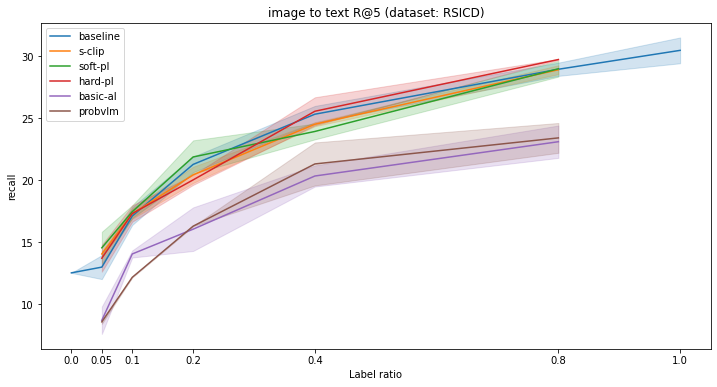

baseline image_to_text_R@5 UCM


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
1064   base     NaN  None  64  image_to_text_R@5     UCM      0  0.00   False   
1153   base     NaN  None  64  image_to_text_R@5     UCM     25  0.05   False   
1154   base     NaN  None  64  image_to_text_R@5     UCM     25  0.10   False   
1155   base     NaN  None  64  image_to_text_R@5     UCM     25  0.20   False   
1156   base     NaN  None  64  image_to_text_R@5     UCM     25  0.40   False   
1157   base     NaN  None  64  image_to_text_R@5     UCM     25  0.80   False   
1158   base     NaN  None  64  image_to_text_R@5     UCM     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
1064  0.00005       0.0  29.520  0.000000     2   
1153  0.00005      25.0  34.954  1.704444     5   
1154  0.00005      25.0  39.810  3.220877     5   
1155  0.00005      25.0  48.286  2.395074     5   
1156  0.00005      25.0  52.000  2.412955     5   
1157  0.00005      25.0  55.716  1.784637     5   
1158  0.00005      25.0  58.384  1.562380     5   

                                           
                                      all  
1064                       [29.52, 29.52]  
1153  [36.19, 35.24, 36.67, 32.38, 34.29]  
1154  [36.67, 39.52, 42.86, 43.33, 36.67]  
1155    [50.0, 44.76, 50.95, 47.62, 48.1]  
1156  [51.43, 50.48, 49.52, 55.71, 52.86]  
1157   [53.33, 55.24, 55.24, 58.1, 56.67]  
1158     [56.67, 58.1, 60.95, 58.1, 58.1]

s-clip image_to_text_R@5 UCM


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
6836   ours     NaN  ot.image  128  image_to_text_R@5     UCM     25  0.05   
6837   ours     NaN  ot.image  128  image_to_text_R@5     UCM     25  0.10   
6838   ours     NaN  ot.image  128  image_to_text_R@5     UCM     25  0.20   
6839   ours     NaN  ot.image  128  image_to_text_R@5     UCM     25  0.40   
6840   ours     NaN  ot.image  128  image_to_text_R@5     UCM     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
6836   False  0.00005      25.0  36.092  2.085454     5   
6837   False  0.00005      25.0  42.478  0.854178     5   
6838   False  0.00005      25.0  50.474  1.064368     5   
6839   False  0.00005      25.0  49.052  2.128737     5   
6840   False  0.00005      25.0  59.050  2.936614     5   

                                           
                                      all  
6836  [35.71, 33.81, 35.71, 35.71, 39.52]  
6837  [42.86, 40.95, 42.86, 42.86, 42.86]  
6838  [50.95, 48.57, 50.95, 50.95, 50.95]  
6839      [48.1, 52.86, 48.1, 48.1, 48.1]  
6840   [60.48, 53.81, 60.48, 60.48, 60.0]

soft-pl image_to_text_R@5 UCM


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                              
10061   ours     NaN  soft.text  64  image_to_text_R@5     UCM     30  0.05   
10062   ours     NaN  soft.text  64  image_to_text_R@5     UCM     30  0.10   
10063   ours     NaN  soft.text  64  image_to_text_R@5     UCM     30  0.20   
10064   ours     NaN  soft.text  64  image_to_text_R@5     UCM     30  0.40   
10065   ours     NaN  soft.text  64  image_to_text_R@5     UCM     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
10061   False  0.00005      30.0  37.334  1.737910     5   
10062   False  0.00005      30.0  40.286  3.309151     5   
10063   False  0.00005      30.0  47.240  2.743866     5   
10064   False  0.00005      30.0  52.952  3.537438     5   
10065   False  0.00005      30.0  55.428  1.043417     5   

                                            
                                       all  
10061   [38.57, 35.71, 35.24, 38.1, 39.05]  
10062  [38.57, 46.19, 39.05, 39.05, 38.57]  
10063  [49.05, 42.86, 46.19, 49.05, 49.05]  
10064  [52.38, 47.62, 56.19, 56.19, 52.38]  
10065  [55.71, 55.24, 56.67, 53.81, 55.71]

hard-pl image_to_text_R@5 UCM


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
3836   ours     NaN  hard.text  64  image_to_text_R@5     UCM     25  0.05   
3837   ours     NaN  hard.text  64  image_to_text_R@5     UCM     25  0.10   
3838   ours     NaN  hard.text  64  image_to_text_R@5     UCM     25  0.20   
3839   ours     NaN  hard.text  64  image_to_text_R@5     UCM     25  0.40   
3840   ours     NaN  hard.text  64  image_to_text_R@5     UCM     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
3836   False  0.00005      25.0  35.622  4.884902     5   
3837   False  0.00005      25.0  42.760  1.915568     5   
3838   False  0.00005      25.0  47.810  3.423543     5   
3839   False  0.00005      25.0  54.666  3.020576     5   
3840   False  0.00005      25.0  57.052  2.343399     5   

                                                         
                                                    all  
3836  [34.29, 33.81, 32.86, 44.29, 32.86, 32.86, 30....  
3837  [40.48, 44.76, 41.9, 44.76, 41.9, 40.48, 44.76...  
3838  [50.0, 51.9, 48.57, 44.29, 44.29, 44.29, 48.57...  
3839         [54.76, 57.62, 50.95, 52.38, 57.62, 53.81]  
3840  [58.1, 52.86, 58.1, 58.1, 58.1, 54.29, 52.86, ...

basic-al image_to_text_R@5 UCM


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
32    base     2.0  None  64  image_to_text_R@5     UCM     20  0.05   False   
80    base     5.0  None  64  image_to_text_R@5     UCM     20  0.10   False   
128   base    10.0  None  64  image_to_text_R@5     UCM     20  0.20   False   
176   base    20.0  None  64  image_to_text_R@5     UCM     20  0.40   False   
224   base    40.0  None  64  image_to_text_R@5     UCM     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
32   0.00005      10.0  33.238  2.943802     5   
80   0.00005      10.0  36.192  4.795667     5   
128  0.00005      10.0  44.762  3.704918     5   
176  0.00005      10.0  49.240  1.040673     5   
224  0.00005      10.0  52.952  0.783243     5   

                                          
                                     all  
32   [29.52, 36.19, 32.86, 36.19, 31.43]  
80   [33.81, 34.29, 34.29, 44.76, 33.81]  
128  [47.62, 47.62, 45.24, 38.57, 44.76]  
176       [50.0, 50.0, 48.1, 48.1, 50.0]  
224  [52.38, 52.38, 53.81, 53.81, 52.38]

probvlm image_to_text_R@5 UCM


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
8     base     2.0  None  32  image_to_text_R@5     UCM     25  0.05    True   
56    base     5.0  None  32  image_to_text_R@5     UCM     25  0.10    True   
104   base    10.0  None  32  image_to_text_R@5     UCM     25  0.20    True   
152   base    20.0  None  32  image_to_text_R@5     UCM     25  0.40    True   
200   base    40.0  None  32  image_to_text_R@5     UCM     25  0.80    True   

          lr AL.epochs   value                  \
                          mean       std count   
8    0.00005      10.0  29.812  1.493693     5   
56   0.00005      10.0  34.760  0.000000     5   
104  0.00005      10.0  43.330  0.000000     5   
152  0.00005      10.0  49.140  4.208943     5   
200  0.00005      10.0  49.525  6.075440     4   

                                          
                                     all  
8    [30.48, 27.14, 30.48, 30.48, 30.48]  
56   [34.76, 34.76, 34.76, 34.76, 34.76]  
104  [43.33, 43.33, 43.33, 43.33, 43.33]  
152     [51.9, 51.9, 51.9, 42.38, 47.62]  
200         [54.29, 55.24, 43.81, 44.76]

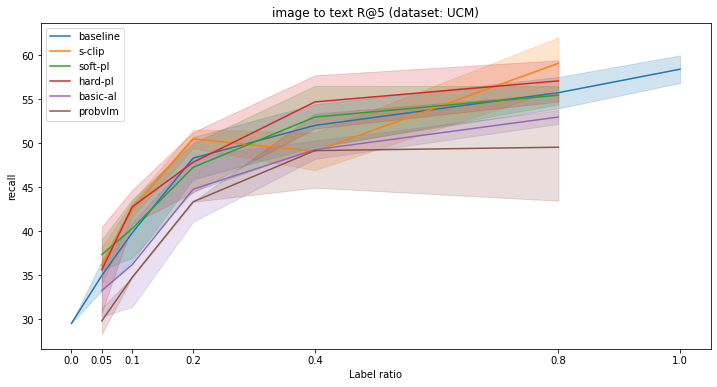

baseline image_to_text_R@5 Sydney


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
961    base     NaN  None  64  image_to_text_R@5  Sydney      0  0.00   False   
1050   base     NaN  None  64  image_to_text_R@5  Sydney     25  0.05   False   
1051   base     NaN  None  64  image_to_text_R@5  Sydney     25  0.10   False   
1052   base     NaN  None  64  image_to_text_R@5  Sydney     25  0.20   False   
1053   base     NaN  None  64  image_to_text_R@5  Sydney     25  0.40   False   
1054   base     NaN  None  64  image_to_text_R@5  Sydney     25  0.80   False   
1055   base     NaN  None  64  image_to_text_R@5  Sydney     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
961   0.00005       0.0   7.040  0.000000     2   
1050  0.00005      25.0   9.498  1.629193     5   
1051  0.00005      25.0  10.944  1.842099     5   
1052  0.00005      25.0  15.454  1.396954     5   
1053  0.00005      25.0  25.954  1.208338     5   
1054  0.00005      25.0  39.274  1.375384     5   
1055  0.00005      25.0  38.270  1.289981     5   

                                           
                                      all  
961                          [7.04, 7.04]  
1050      [7.85, 9.26, 8.45, 9.86, 12.07]  
1051    [9.86, 11.87, 9.05, 13.68, 10.26]  
1052     [14.69, 17.1, 13.48, 15.9, 16.1]  
1053  [27.36, 25.55, 26.56, 26.16, 24.14]  
1054  [39.64, 40.64, 37.22, 40.24, 38.63]  
1055  [40.44, 37.63, 38.43, 37.63, 37.22]

s-clip image_to_text_R@5 Sydney


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
6711   ours     NaN  ot.image  128  image_to_text_R@5  Sydney     25  0.05   
6712   ours     NaN  ot.image  128  image_to_text_R@5  Sydney     25  0.10   
6713   ours     NaN  ot.image  128  image_to_text_R@5  Sydney     25  0.20   
6714   ours     NaN  ot.image  128  image_to_text_R@5  Sydney     25  0.40   
6715   ours     NaN  ot.image  128  image_to_text_R@5  Sydney     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
6711   False  0.00005      25.0   9.940  0.862583     5   
6712   False  0.00005      25.0  11.748  0.720014     5   
6713   False  0.00005      25.0  13.120  0.089443     5   
6714   False  0.00005      25.0  19.152  0.093915     5   
6715   False  0.00005      25.0  31.268  1.657564     5   

                                           
                                      all  
6711      [9.86, 11.27, 9.86, 9.86, 8.85]  
6712  [12.07, 10.46, 12.07, 12.07, 12.07]  
6713  [13.08, 13.28, 13.08, 13.08, 13.08]  
6714  [19.11, 19.32, 19.11, 19.11, 19.11]  
6715   [31.79, 28.37, 31.79, 31.79, 32.6]

soft-pl image_to_text_R@5 Sydney


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
9911   ours     NaN  soft.text  64  image_to_text_R@5  Sydney     30  0.05   
9912   ours     NaN  soft.text  64  image_to_text_R@5  Sydney     30  0.10   
9913   ours     NaN  soft.text  64  image_to_text_R@5  Sydney     30  0.20   
9914   ours     NaN  soft.text  64  image_to_text_R@5  Sydney     30  0.40   
9915   ours     NaN  soft.text  64  image_to_text_R@5  Sydney     30  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
9911   False  0.00005      30.0   9.294  0.846540     5   
9912   False  0.00005      30.0  10.786  1.423808     5   
9913   False  0.00005      30.0  14.526  0.929774     5   
9914   False  0.00005      30.0  19.920  1.479223     5   
9915   False  0.00005      30.0  27.928  1.676595     5   

                                           
                                      all  
9911     [10.06, 8.25, 8.85, 10.26, 9.05]  
9912    [11.67, 12.27, 9.26, 9.26, 11.47]  
9913   [13.88, 15.09, 15.9, 13.88, 13.88]  
9914  [18.31, 20.72, 21.13, 21.13, 18.31]  
9915  [29.38, 28.17, 25.35, 27.36, 29.38]

hard-pl image_to_text_R@5 Sydney


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
3711   ours     NaN  hard.text  64  image_to_text_R@5  Sydney     25  0.05   
3712   ours     NaN  hard.text  64  image_to_text_R@5  Sydney     25  0.10   
3713   ours     NaN  hard.text  64  image_to_text_R@5  Sydney     25  0.20   
3714   ours     NaN  hard.text  64  image_to_text_R@5  Sydney     25  0.40   
3715   ours     NaN  hard.text  64  image_to_text_R@5  Sydney     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
3711   False  0.00005      25.0   9.900  0.822830     5   
3712   False  0.00005      25.0  11.548  1.408020     5   
3713   False  0.00005      25.0  12.234  1.341801     5   
3714   False  0.00005      25.0  18.390  1.413895     5   
3715   False  0.00005      25.0  24.706  1.712828     5   

                                                         
                                                    all  
3711  [9.66, 9.26, 10.66, 9.05, 10.87, 10.66, 9.05, ...  
3712  [10.26, 10.66, 13.08, 10.66, 13.08, 10.26, 10....  
3713  [12.47, 13.88, 13.08, 10.87, 10.87, 10.87, 13....  
3714           [19.32, 17.1, 20.32, 18.11, 17.1, 20.72]  
3715  [23.94, 27.77, 23.94, 23.94, 23.94, 25.35, 27....

basic-al image_to_text_R@5 Sydney


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
31    base     2.0  None  64  image_to_text_R@5  Sydney     20  0.05   False   
79    base     5.0  None  64  image_to_text_R@5  Sydney     20  0.10   False   
127   base    10.0  None  64  image_to_text_R@5  Sydney     20  0.20   False   
175   base    20.0  None  64  image_to_text_R@5  Sydney     20  0.40   False   
223   base    40.0  None  64  image_to_text_R@5  Sydney     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
31   0.00005      10.0   6.638  1.357229     5   
79   0.00005      10.0  10.540  0.268328     5   
127  0.00005      10.0  14.370  4.299622     5   
175  0.00005      10.0  21.528  2.755044     5   
223  0.00005      10.0  31.872  0.996855     5   

                                          
                                     all  
31        [6.64, 5.23, 8.45, 5.43, 7.44]  
79   [10.66, 10.66, 10.66, 10.06, 10.66]  
127    [17.51, 17.51, 9.66, 17.51, 9.66]  
175  [23.54, 23.54, 18.51, 18.51, 23.54]  
223     [32.6, 32.6, 30.78, 30.78, 32.6]

probvlm image_to_text_R@5 Sydney


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
7     base     2.0  None  32  image_to_text_R@5  Sydney     25  0.05    True   
55    base     5.0  None  32  image_to_text_R@5  Sydney     25  0.10    True   
103   base    10.0  None  32  image_to_text_R@5  Sydney     25  0.20    True   
151   base    20.0  None  32  image_to_text_R@5  Sydney     25  0.40    True   
199   base    40.0  None  32  image_to_text_R@5  Sydney     25  0.80    True   

          lr AL.epochs   value                  \
                          mean       std count   
7    0.00005      10.0   8.772  0.720014     5   
55   0.00005      10.0  11.070  0.000000     5   
103  0.00005      10.0  10.870  0.000000     5   
151  0.00005      10.0  15.088  0.791846     5   
199  0.00005      10.0  18.610  1.278045     4   

                                          
                                     all  
7        [8.45, 10.06, 8.45, 8.45, 8.45]  
55   [11.07, 11.07, 11.07, 11.07, 11.07]  
103  [10.87, 10.87, 10.87, 10.87, 10.87]  
151  [15.49, 15.49, 15.49, 13.68, 15.29]  
199          [19.11, 19.92, 16.9, 18.51]

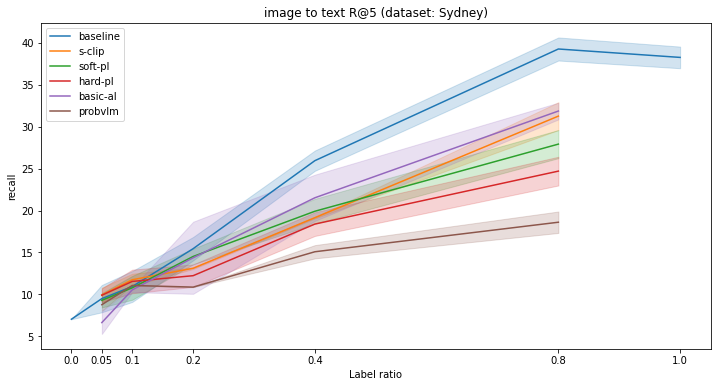

baseline text_to_image_R@5 RSICD


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
1785   base     NaN  None  64  text_to_image_R@5   RSICD      0  0.00   False   
1874   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.05   False   
1875   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.10   False   
1876   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.20   False   
1877   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.40   False   
1878   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.80   False   
1879   base     NaN  None  64  text_to_image_R@5   RSICD     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
1785  0.00005       0.0  14.270  0.000000     2   
1874  0.00005      25.0  13.122  0.420678     5   
1875  0.00005      25.0  16.690  0.939920     5   
1876  0.00005      25.0  20.806  1.018052     5   
1877  0.00005      25.0  24.904  0.638968     5   
1878  0.00005      25.0  29.532  0.979525     5   
1879  0.00005      25.0  31.070  1.026913     5   

                                           
                                      all  
1785                       [14.27, 14.27]  
1874  [13.27, 13.54, 12.72, 12.63, 13.45]  
1875  [15.65, 18.12, 16.47, 16.19, 17.02]  
1876  [20.31, 19.67, 22.42, 20.77, 20.86]  
1877  [24.15, 24.61, 25.89, 24.89, 24.98]  
1878  [28.45, 30.92, 28.82, 29.46, 30.01]  
1879  [30.19, 30.74, 32.85, 30.74, 30.83]

s-clip text_to_image_R@5 RSICD


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
7711   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.05   
7712   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.10   
7713   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.20   
7714   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.40   
7715   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
7711   False  0.00005      25.0  13.924  0.474847     5   
7712   False  0.00005      25.0  17.196  0.818401     5   
7713   False  0.00005      25.0  19.978  0.286217     5   
7714   False  0.00005      25.0  23.462  0.898899     5   
7715   False  0.00005      25.0  28.968  0.733430     5   

                                           
                                      all  
7711  [14.27, 13.45, 14.27, 14.27, 13.36]  
7712  [16.83, 18.66, 16.83, 16.83, 16.83]  
7713  [19.85, 20.49, 19.85, 19.85, 19.85]  
7714  [23.06, 25.07, 23.06, 23.06, 23.06]  
7715  [28.64, 30.28, 28.64, 28.64, 28.64]

soft-pl text_to_image_R@5 RSICD


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                              
11111   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.05   
11112   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.10   
11113   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.20   
11114   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.40   
11115   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
11111   False  0.00005      30.0  14.638  0.614549     5   
11112   False  0.00005      30.0  18.152  0.697653     5   
11113   False  0.00005      30.0  22.234  1.206764     5   
11114   False  0.00005      30.0  25.712  0.497112     5   
11115   False  0.00005      30.0  30.062  1.053551     5   

                                            
                                       all  
11111  [14.73, 13.63, 14.91, 14.64, 15.28]  
11112   [17.84, 19.4, 17.84, 17.84, 17.84]  
11113   [23.06, 21.59, 20.4, 23.06, 23.06]  
11114  [26.26, 24.98, 25.62, 25.62, 26.08]  
11115  [28.91, 30.83, 30.74, 30.92, 28.91]

hard-pl text_to_image_R@5 RSICD


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
4711   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.05   
4712   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.10   
4713   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.20   
4714   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.40   
4715   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
4711   False  0.00005      25.0  13.630  0.606795     5   
4712   False  0.00005      25.0  17.988  1.053812     5   
4713   False  0.00005      25.0  20.258  0.612021     5   
4714   False  0.00005      25.0  25.616  0.849723     5   
4715   False  0.00005      25.0  30.248  0.532184     5   

                                                         
                                                    all  
4711  [12.99, 13.45, 14.27, 13.17, 14.27, 14.27, 13....  
4712  [16.38, 17.84, 18.94, 17.84, 18.94, 16.38, 17....  
4713  [19.21, 20.68, 20.22, 20.59, 20.59, 20.59, 20....  
4714          [24.79, 26.44, 25.71, 24.7, 26.44, 26.35]  
4715  [30.01, 31.2, 30.01, 30.01, 30.01, 30.28, 31.2...

basic-al text_to_image_R@5 RSICD


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
39    base     2.0  None  64  text_to_image_R@5   RSICD     20  0.05   False   
87    base     5.0  None  64  text_to_image_R@5   RSICD     20  0.10   False   
135   base    10.0  None  64  text_to_image_R@5   RSICD     20  0.20   False   
183   base    20.0  None  64  text_to_image_R@5   RSICD     20  0.40   False   
231   base    40.0  None  64  text_to_image_R@5   RSICD     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
39   0.00005      10.0   8.324  1.836608     5   
87   0.00005      10.0  12.422  0.075299     5   
135  0.00005      10.0  15.830  1.833548     5   
183  0.00005      10.0  20.806  1.456942     5   
231  0.00005      10.0  24.210  0.301247     5   

                                          
                                     all  
39       [8.05, 6.86, 11.34, 6.86, 8.51]  
87   [12.44, 12.35, 12.35, 12.53, 12.44]  
135   [16.1, 16.38, 17.02, 12.63, 17.02]  
183  [21.87, 21.87, 19.21, 19.21, 21.87]  
231  [24.43, 24.43, 23.88, 23.88, 24.43]

probvlm text_to_image_R@5 RSICD


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
15    base     2.0  None  32  text_to_image_R@5   RSICD     25  0.05    True   
63    base     5.0  None  32  text_to_image_R@5   RSICD     25  0.10    True   
111   base    10.0  None  32  text_to_image_R@5   RSICD     25  0.20    True   
159   base    20.0  None  32  text_to_image_R@5   RSICD     25  0.40    True   
207   base    40.0  None  32  text_to_image_R@5   RSICD     25  0.80    True   

          lr AL.epochs   value                  \
                          mean       std count   
15   0.00005      10.0   7.760  0.245967     5   
63   0.00005      10.0  12.630  0.000000     5   
111  0.00005      10.0  17.020  0.000000     5   
159  0.00005      10.0  21.082  0.339588     5   
207  0.00005      10.0  24.450  1.321439     4   

                                          
                                     all  
15        [7.87, 7.32, 7.87, 7.87, 7.87]  
63   [12.63, 12.63, 12.63, 12.63, 12.63]  
111  [17.02, 17.02, 17.02, 17.02, 17.02]  
159  [21.32, 21.32, 21.32, 20.59, 20.86]  
207         [23.24, 25.89, 25.25, 23.42]

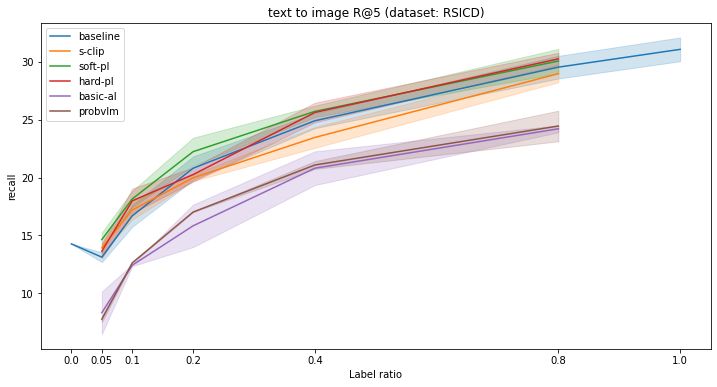

baseline text_to_image_R@5 UCM


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
1991   base     NaN  None  64  text_to_image_R@5     UCM      0  0.00   False   
2080   base     NaN  None  64  text_to_image_R@5     UCM     25  0.05   False   
2081   base     NaN  None  64  text_to_image_R@5     UCM     25  0.10   False   
2082   base     NaN  None  64  text_to_image_R@5     UCM     25  0.20   False   
2083   base     NaN  None  64  text_to_image_R@5     UCM     25  0.40   False   
2084   base     NaN  None  64  text_to_image_R@5     UCM     25  0.80   False   
2085   base     NaN  None  64  text_to_image_R@5     UCM     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
1991  0.00005       0.0  31.430  0.000000     2   
2080  0.00005      25.0  35.142  3.341118     5   
2081  0.00005      25.0  38.096  1.814657     5   
2082  0.00005      25.0  48.666  1.033697     5   
2083  0.00005      25.0  50.666  1.735578     5   
2084  0.00005      25.0  55.334  1.824179     5   
2085  0.00005      25.0  59.714  2.558062     5   

                                           
                                      all  
1991                       [31.43, 31.43]  
2080   [37.14, 36.19, 39.05, 31.9, 31.43]  
2081   [35.71, 40.0, 39.05, 36.67, 39.05]  
2082   [50.0, 48.57, 47.14, 49.05, 48.57]  
2083   [53.33, 50.0, 48.57, 50.95, 50.48]  
2084  [54.29, 54.29, 54.76, 58.57, 54.76]  
2085  [58.57, 61.43, 55.71, 61.43, 61.43]

s-clip text_to_image_R@5 UCM


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
7961   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.05   
7962   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.10   
7963   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.20   
7964   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.40   
7965   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
7961   False  0.00005      25.0  36.096  1.829393     5   
7962   False  0.00005      25.0  43.140  0.424853     5   
7963   False  0.00005      25.0  52.950  0.849706     5   
7964   False  0.00005      25.0  51.900  0.000000     5   
7965   False  0.00005      25.0  58.854  1.489221     5   

                                           
                                      all  
7961    [34.76, 38.1, 34.76, 34.76, 38.1]  
7962  [43.33, 42.38, 43.33, 43.33, 43.33]  
7963  [53.33, 51.43, 53.33, 53.33, 53.33]  
7964       [51.9, 51.9, 51.9, 51.9, 51.9]  
7965  [59.52, 56.19, 59.52, 59.52, 59.52]

soft-pl text_to_image_R@5 UCM


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                              
11411   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.05   
11412   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.10   
11413   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.20   
11414   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.40   
11415   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
11411   False  0.00005      30.0  38.192  3.292107     5   
11412   False  0.00005      30.0  42.476  1.362289     5   
11413   False  0.00005      30.0  46.474  0.926974     5   
11414   False  0.00005      30.0  52.188  1.192841     5   
11415   False  0.00005      30.0  57.618  1.431667     5   

                                            
                                       all  
11411  [40.48, 33.33, 36.19, 40.48, 40.48]  
11412  [42.38, 44.76, 41.43, 41.43, 42.38]  
11413  [47.14, 45.71, 45.24, 47.14, 47.14]  
11414    [53.33, 50.48, 51.9, 51.9, 53.33]  
11415  [57.14, 59.05, 55.71, 59.05, 57.14]

hard-pl text_to_image_R@5 UCM


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
4961   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.05   
4962   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.10   
4963   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.20   
4964   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.40   
4965   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
4961   False  0.00005      25.0  35.430  3.755210     5   
4962   False  0.00005      25.0  43.906  3.390403     5   
4963   False  0.00005      25.0  48.476  3.202246     5   
4964   False  0.00005      25.0  53.998  3.096784     5   
4965   False  0.00005      25.0  59.808  2.553590     5   

                                                         
                                                    all  
4961  [34.29, 35.24, 32.86, 41.9, 32.86, 32.86, 35.2...  
4962  [41.43, 47.62, 41.43, 47.62, 41.43, 41.43, 47....  
4963  [46.19, 50.95, 52.86, 46.19, 46.19, 46.19, 52....  
4964          [58.57, 53.33, 50.0, 54.76, 53.33, 55.24]  
4965  [60.95, 55.24, 60.95, 60.95, 60.95, 56.67, 55....

basic-al text_to_image_R@5 UCM


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
41    base     2.0  None  64  text_to_image_R@5     UCM     20  0.05   False   
89    base     5.0  None  64  text_to_image_R@5     UCM     20  0.10   False   
137   base    10.0  None  64  text_to_image_R@5     UCM     20  0.20   False   
185   base    20.0  None  64  text_to_image_R@5     UCM     20  0.40   False   
233   base    40.0  None  64  text_to_image_R@5     UCM     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
41   0.00005      10.0  33.428  1.915690     5   
89   0.00005      10.0  39.046  1.064368     5   
137  0.00005      10.0  42.856  1.344388     5   
185  0.00005      10.0  48.666  3.127496     5   
233  0.00005      10.0  52.858  1.303580     5   

                                          
                                     all  
41   [35.71, 32.38, 31.43, 32.38, 35.24]  
89   [38.57, 38.57, 38.57, 40.95, 38.57]  
137  [43.33, 43.33, 43.33, 40.48, 43.81]  
185  [50.95, 50.95, 45.24, 45.24, 50.95]  
233  [53.81, 53.81, 51.43, 51.43, 53.81]

probvlm text_to_image_R@5 UCM


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
17    base     2.0  None  32  text_to_image_R@5     UCM     25  0.05    True   
65    base     5.0  None  32  text_to_image_R@5     UCM     25  0.10    True   
113   base    10.0  None  32  text_to_image_R@5     UCM     25  0.20    True   
161   base    20.0  None  32  text_to_image_R@5     UCM     25  0.40    True   
209   base    40.0  None  32  text_to_image_R@5     UCM     25  0.80    True   

          lr AL.epochs    value                  \
                           mean       std count   
17   0.00005      10.0  29.2420  2.768252     5   
65   0.00005      10.0  36.1900  0.000000     5   
113  0.00005      10.0  42.3800  0.000000     5   
161  0.00005      10.0  45.5280  2.768252     5   
209  0.00005      10.0  47.1425  1.944897     4   

                                          
                                     all  
17   [30.48, 24.29, 30.48, 30.48, 30.48]  
65   [36.19, 36.19, 36.19, 36.19, 36.19]  
113  [42.38, 42.38, 42.38, 42.38, 42.38]  
161  [44.29, 44.29, 44.29, 44.29, 50.48]  
209         [48.57, 49.05, 45.71, 45.24]

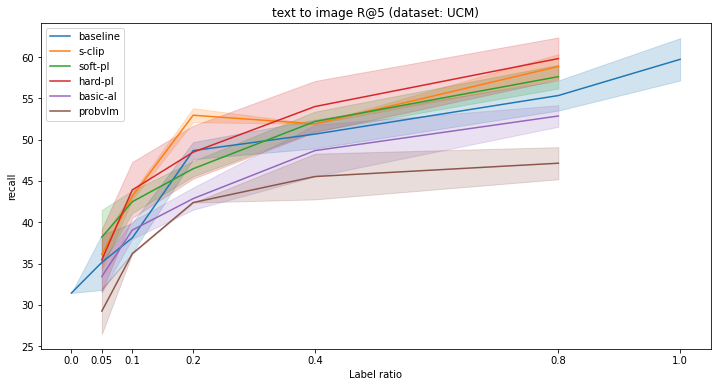

baseline text_to_image_R@5 Sydney


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
1888   base     NaN  None  64  text_to_image_R@5  Sydney      0  0.00   False   
1977   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.05   False   
1978   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.10   False   
1979   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.20   False   
1980   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.40   False   
1981   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.80   False   
1982   base     NaN  None  64  text_to_image_R@5  Sydney     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
1888  0.00005       0.0  10.660  0.000000     2   
1977  0.00005      25.0  10.746  0.677370     5   
1978  0.00005      25.0  14.406  1.293940     5   
1979  0.00005      25.0  18.350  2.141775     5   
1980  0.00005      25.0  27.044  1.087764     5   
1981  0.00005      25.0  36.578  1.041091     5   
1982  0.00005      25.0  37.666  0.438668     5   

                                           
                                      all  
1888                       [10.66, 10.66]  
1977   [9.86, 11.47, 11.27, 10.87, 10.26]  
1978   [13.48, 16.1, 13.28, 13.68, 15.49]  
1979   [15.49, 19.52, 19.52, 16.7, 20.52]  
1980  [26.36, 28.57, 25.96, 27.77, 26.56]  
1981  [35.81, 37.63, 36.82, 37.42, 35.21]  
1982  [37.42, 38.03, 37.02, 38.03, 37.83]

s-clip text_to_image_R@5 Sydney


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
7836   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.05   
7837   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.10   
7838   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.20   
7839   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.40   
7840   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
7836   False  0.00005      25.0   9.742  1.077785     5   
7837   False  0.00005      25.0  14.568  0.720014     5   
7838   False  0.00005      25.0  17.140  0.357771     5   
7839   False  0.00005      25.0  22.014  1.529470     5   
7840   False  0.00005      25.0  31.710  0.178885     5   

                                           
                                      all  
7836      [9.26, 9.26, 9.26, 9.26, 11.67]  
7837  [14.89, 13.28, 14.89, 14.89, 14.89]  
7838       [17.3, 16.5, 17.3, 17.3, 17.3]  
7839  [21.33, 24.75, 21.33, 21.33, 21.33]  
7840  [31.79, 31.39, 31.79, 31.79, 31.79]

soft-pl text_to_image_R@5 Sydney


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                              
11261   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.05   
11262   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.10   
11263   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.20   
11264   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.40   
11265   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
11261   False  0.00005      30.0  11.146  2.197494     5   
11262   False  0.00005      30.0  12.714  1.453850     5   
11263   False  0.00005      30.0  17.382  0.719458     5   
11264   False  0.00005      30.0  20.806  1.218536     5   
11265   False  0.00005      30.0  27.848  0.442063     5   

                                            
                                       all  
11261    [13.48, 10.46, 9.26, 13.48, 9.05]  
11262  [12.27, 15.29, 11.87, 11.87, 12.27]  
11263      [17.3, 16.5, 18.51, 17.3, 17.3]  
11264  [19.52, 21.13, 21.93, 21.93, 19.52]  
11265  [27.97, 28.37, 27.16, 27.77, 27.97]

hard-pl text_to_image_R@5 Sydney


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
4836   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.05   
4837   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.10   
4838   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.20   
4839   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.40   
4840   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
4836   False  0.00005      25.0   9.656  0.752350     5   
4837   False  0.00005      25.0  12.876  0.493994     5   
4838   False  0.00005      25.0  16.016  0.848664     5   
4839   False  0.00005      25.0  21.328  1.865508     5   
4840   False  0.00005      25.0  26.200  0.089443     5   

                                                         
                                                    all  
4836  [9.26, 10.66, 9.05, 10.26, 9.05, 9.05, 9.66, 9...  
4837  [13.68, 12.88, 12.47, 12.88, 12.47, 13.68, 12....  
4838  [14.69, 16.3, 15.69, 16.7, 16.7, 16.7, 15.69, ...  
4839         [19.72, 23.34, 19.72, 20.52, 23.34, 19.32]  
4840  [26.16, 26.36, 26.16, 26.16, 26.16, 26.96, 26....

basic-al text_to_image_R@5 Sydney


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
40    base     2.0  None  64  text_to_image_R@5  Sydney     20  0.05   False   
88    base     5.0  None  64  text_to_image_R@5  Sydney     20  0.10   False   
136   base    10.0  None  64  text_to_image_R@5  Sydney     20  0.20   False   
184   base    20.0  None  64  text_to_image_R@5  Sydney     20  0.40   False   
232   base    40.0  None  64  text_to_image_R@5  Sydney     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
40   0.00005      10.0   8.250  0.648074     5   
88   0.00005      10.0  10.464  1.797799     5   
136  0.00005      10.0  16.096  4.025001     5   
184  0.00005      10.0  21.324  3.855967     5   
232  0.00005      10.0  33.122  1.763667     5   

                                          
                                     all  
40        [7.65, 7.85, 8.85, 7.85, 9.05]  
88       [9.66, 9.66, 9.66, 13.68, 9.66]  
136   [20.12, 20.12, 12.07, 16.1, 12.07]  
184    [24.14, 24.14, 17.1, 17.1, 24.14]  
232  [34.41, 34.41, 31.19, 31.19, 34.41]

probvlm text_to_image_R@5 Sydney


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
16    base     2.0  None  32  text_to_image_R@5  Sydney     25  0.05    True   
64    base     5.0  None  32  text_to_image_R@5  Sydney     25  0.10    True   
112   base    10.0  None  32  text_to_image_R@5  Sydney     25  0.20    True   
160   base    20.0  None  32  text_to_image_R@5  Sydney     25  0.40    True   
208   base    40.0  None  32  text_to_image_R@5  Sydney     25  0.80    True   

          lr AL.epochs    value                  \
                           mean       std count   
16   0.00005      10.0   8.8100  0.089443     5   
64   0.00005      10.0  13.4800  0.000000     5   
112  0.00005      10.0  12.6800  0.000000     5   
160  0.00005      10.0  15.9780  0.718624     5   
208  0.00005      10.0  20.2225  1.985806     4   

                                          
                                     all  
16        [8.85, 8.65, 8.85, 8.85, 8.85]  
64   [13.48, 13.48, 13.48, 13.48, 13.48]  
112  [12.68, 12.68, 12.68, 12.68, 12.68]  
160      [15.9, 15.9, 15.9, 15.09, 17.1]  
208         [21.13, 22.13, 17.51, 20.12]

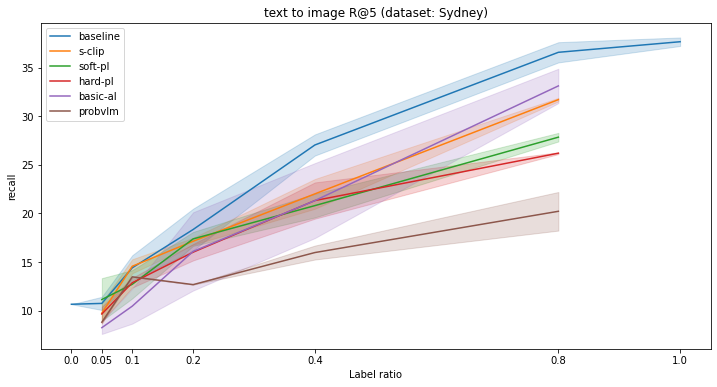

In [18]:
metrics = ['image_to_text_R@5', 'text_to_image_R@5']
datasets = ['RSICD', 'UCM', 'Sydney']
for metric in metrics:
    for dataset in datasets:
        only_scores = plot_model_comparison(results_dict, metric, dataset)
#         print(only_scores)
#         for model in only_scores:
#             scores_grouped = only_scores[model]
#             for group_of_scores in scores_grouped:
#                 print(group_of_scores)
#                 plt.scatter([0] * len(group_of_scores), sorted(group_of_scores))
#                 plt.title(f"{model} {dataset} {metric}")
#                 plt.show()

RSICD-CLS zeroshot-val-top1
baseline zeroshot-val-top1 RSICD-CLS


method AL.iter    PL  bs             metric    dataset epochs ratio  \
                                                                           
2300   base     NaN  None  64  zeroshot-val-top1  RSICD-CLS      0  0.00   
2390   base     NaN  None  64  zeroshot-val-top1  RSICD-CLS     25  0.05   
2391   base     NaN  None  64  zeroshot-val-top1  RSICD-CLS     25  0.10   
2392   base     NaN  None  64  zeroshot-val-top1  RSICD-CLS     25  0.20   
2393   base     NaN  None  64  zeroshot-val-top1  RSICD-CLS     25  0.40   
2394   base     NaN  None  64  zeroshot-val-top1  RSICD-CLS     25  0.80   
2395   base     NaN  None  64  zeroshot-val-top1  RSICD-CLS     25  1.00   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
2300   False  0.00005       0.0  53.710  0.000000     3   
2390   False  0.00005      25.0  56.652  1.917008     5   
2391   False  0.00005      25.0  63.916  1.673090     5   
2392   False  0.00005      25.0  72.700  1.399071     5   
2393   False  0.00005      25.0  83.220  1.070047     5   
2394   False  0.00005      25.0  84.592  2.209835     5   
2395   False  0.00005      25.0  85.142  1.542359     5   

                                           
                                      all  
2300                [53.71, 53.71, 53.71]  
2390  [58.28, 57.46, 57.82, 56.18, 53.52]  
2391  [63.22, 65.32, 65.97, 63.13, 61.94]  
2392  [72.19, 72.83, 74.29, 73.56, 70.63]  
2393  [83.81, 83.99, 81.88, 84.17, 82.25]  
2394  [86.28, 81.52, 85.45, 83.07, 86.64]  
2395  [87.01, 83.99, 86.64, 83.99, 84.08]

s-clip zeroshot-val-top1 RSICD-CLS


method AL.iter        PL   bs             metric    dataset epochs ratio  \
                                                                                
8336   ours     NaN  ot.image  128  zeroshot-val-top1  RSICD-CLS     25  0.05   
8337   ours     NaN  ot.image  128  zeroshot-val-top1  RSICD-CLS     25  0.10   
8338   ours     NaN  ot.image  128  zeroshot-val-top1  RSICD-CLS     25  0.20   
8339   ours     NaN  ot.image  128  zeroshot-val-top1  RSICD-CLS     25  0.40   
8340   ours     NaN  ot.image  128  zeroshot-val-top1  RSICD-CLS     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
8336   False  0.00005      25.0  55.884  1.488247     5   
8337   False  0.00005      25.0  64.828  2.128737     5   
8338   False  0.00005      25.0  77.950  1.229837     5   
8339   False  0.00005      25.0  85.580  0.939149     5   
8340   False  0.00005      25.0  86.732  1.024119     5   

                                           
                                      all  
8336  [55.63, 54.35, 55.63, 55.44, 58.37]  
8337  [65.78, 61.02, 65.78, 65.78, 65.78]  
8338      [78.5, 75.75, 78.5, 78.5, 78.5]  
8339       [86.0, 83.9, 86.0, 86.0, 86.0]  
8340   [87.19, 84.9, 87.19, 87.19, 87.19]

soft-pl zeroshot-val-top1 RSICD-CLS


method AL.iter         PL  bs             metric    dataset epochs  \
                                                                           
11861   ours     NaN  soft.text  64  zeroshot-val-top1  RSICD-CLS     30   
11862   ours     NaN  soft.text  64  zeroshot-val-top1  RSICD-CLS     30   
11863   ours     NaN  soft.text  64  zeroshot-val-top1  RSICD-CLS     30   
11864   ours     NaN  soft.text  64  zeroshot-val-top1  RSICD-CLS     30   
11865   ours     NaN  soft.text  64  zeroshot-val-top1  RSICD-CLS     30   

      ratio ProbVLM       lr AL.epochs   value                  \
                                          mean       std count   
11861  0.05   False  0.00005      30.0  57.108  1.777645     5   
11862  0.10   False  0.00005      30.0  63.640  0.868188     5   
11863  0.20   False  0.00005      30.0  77.016  1.222448     5   
11864  0.40   False  0.00005      30.0  83.168  2.388874     5   
11865  0.80   False  0.00005      30.0  88.748  0.948061     5   

                                            
                                       all  
11861   [59.01, 55.81, 55.81, 59.1, 55.81]  
11862  [63.49, 65.14, 63.04, 63.04, 63.49]  
11863  [77.49, 77.77, 74.84, 77.49, 77.49]  
11864   [80.88, 82.8, 85.64, 85.64, 80.88]  
11865  [88.11, 88.47, 88.66, 90.39, 88.11]

hard-pl zeroshot-val-top1 RSICD-CLS


method AL.iter         PL  bs             metric    dataset epochs ratio  \
                                                                                
5336   ours     NaN  hard.text  64  zeroshot-val-top1  RSICD-CLS     25  0.05   
5337   ours     NaN  hard.text  64  zeroshot-val-top1  RSICD-CLS     25  0.10   
5338   ours     NaN  hard.text  64  zeroshot-val-top1  RSICD-CLS     25  0.20   
5339   ours     NaN  hard.text  64  zeroshot-val-top1  RSICD-CLS     25  0.40   
5340   ours     NaN  hard.text  64  zeroshot-val-top1  RSICD-CLS     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
5336   False  0.00005      25.0  59.012  1.691204     5   
5337   False  0.00005      25.0  65.214  2.675253     5   
5338   False  0.00005      25.0  75.314  0.452526     5   
5339   False  0.00005      25.0  82.086  2.044170     5   
5340   False  0.00005      25.0  84.888  0.979398     5   

                                                         
                                                    all  
5336  [57.27, 59.84, 60.38, 57.09, 60.48, 60.38, 52....  
5337  [65.87, 62.4, 67.7, 62.4, 67.7, 65.87, 62.4, 6...  
5338  [75.02, 74.66, 75.57, 75.66, 75.66, 75.66, 75....  
5339         [84.17, 82.98, 78.87, 81.43, 82.98, 81.43]  
5340  [84.45, 86.64, 84.45, 84.45, 84.45, 89.11, 86....

basic-al zeroshot-val-top1 RSICD-CLS


method AL.iter    PL  bs             metric    dataset epochs ratio  \
                                                                          
44    base     2.0  None  64  zeroshot-val-top1  RSICD-CLS     20  0.05   
92    base     5.0  None  64  zeroshot-val-top1  RSICD-CLS     20  0.10   
140   base    10.0  None  64  zeroshot-val-top1  RSICD-CLS     20  0.20   
188   base    20.0  None  64  zeroshot-val-top1  RSICD-CLS     20  0.40   
236   base    40.0  None  64  zeroshot-val-top1  RSICD-CLS     20  0.80   

    ProbVLM       lr AL.epochs   value                  \
                                  mean       std count   
44    False  0.00005      10.0  42.434  2.685280     5   
92    False  0.00005      10.0  57.002  3.735555     5   
140   False  0.00005      10.0  62.452  7.301234     5   
188   False  0.00005      10.0  71.418  3.708082     5   
236   False  0.00005      10.0  78.776  1.500760     5   

                                          
                                     all  
44    [42.09, 39.89, 45.38, 39.8, 45.01]  
92   [58.65, 58.65, 58.65, 50.32, 58.74]  
140  [57.09, 57.09, 70.45, 57.18, 70.45]  
188  [68.71, 68.71, 75.48, 75.48, 68.71]  
236  [77.68, 77.68, 80.42, 80.42, 77.68]

probvlm zeroshot-val-top1 RSICD-CLS


method AL.iter    PL  bs             metric    dataset epochs ratio  \
                                                                          
20    base     2.0  None  32  zeroshot-val-top1  RSICD-CLS     25  0.05   
68    base     5.0  None  32  zeroshot-val-top1  RSICD-CLS     25  0.10   
116   base    10.0  None  32  zeroshot-val-top1  RSICD-CLS     25  0.20   
164   base    20.0  None  32  zeroshot-val-top1  RSICD-CLS     25  0.40   
212   base    40.0  None  32  zeroshot-val-top1  RSICD-CLS     25  0.80   

    ProbVLM       lr AL.epochs    value                  \
                                   mean       std count   
20     True  0.00005      10.0  38.4600  0.290689     5   
68     True  0.00005      10.0  53.6100  0.000000     5   
116    True  0.00005      10.0  61.4800  0.000000     5   
164    True  0.00005      10.0  73.8320  5.242053     5   
212    True  0.00005      10.0  82.2975  1.964729     4   

                                          
                                     all  
20   [38.33, 38.98, 38.33, 38.33, 38.33]  
68   [53.61, 53.61, 53.61, 53.61, 53.61]  
116  [61.48, 61.48, 61.48, 61.48, 61.48]  
164   [77.58, 77.58, 77.58, 69.72, 66.7]  
212          [82.16, 79.6, 84.08, 83.35]

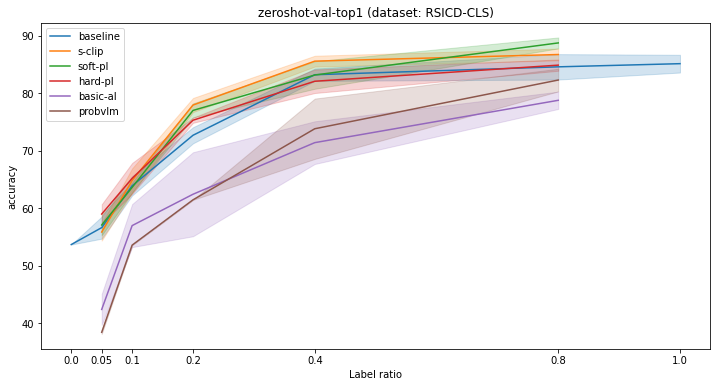

UCM-CLS zeroshot-val-top1
baseline zeroshot-val-top1 UCM-CLS


method AL.iter    PL  bs             metric  dataset epochs ratio  \
                                                                         
2508   base     NaN  None  64  zeroshot-val-top1  UCM-CLS      0  0.00   
2598   base     NaN  None  64  zeroshot-val-top1  UCM-CLS     25  0.05   
2599   base     NaN  None  64  zeroshot-val-top1  UCM-CLS     25  0.10   
2600   base     NaN  None  64  zeroshot-val-top1  UCM-CLS     25  0.20   
2601   base     NaN  None  64  zeroshot-val-top1  UCM-CLS     25  0.40   
2602   base     NaN  None  64  zeroshot-val-top1  UCM-CLS     25  0.80   
2603   base     NaN  None  64  zeroshot-val-top1  UCM-CLS     25  1.00   

     ProbVLM       lr AL.epochs   value                      \
                                   mean           std count   
2508   False  0.00005       0.0  49.050  8.702336e-15     3   
2598   False  0.00005      25.0  53.332  2.104904e+00     5   
2599   False  0.00005      25.0  57.712  1.974062e+00     5   
2600   False  0.00005      25.0  68.476  1.361591e+00     5   
2601   False  0.00005      25.0  71.238  2.924691e+00     5   
2602   False  0.00005      25.0  76.284  1.827438e+00     5   
2603   False  0.00005      25.0  68.666  3.150775e+00     5   

                                           
                                      all  
2508                [49.05, 49.05, 49.05]  
2598  [56.67, 53.33, 52.38, 53.33, 50.95]  
2599  [54.76, 59.52, 59.52, 57.62, 57.14]  
2600   [66.67, 70.0, 68.57, 69.52, 67.62]  
2601     [72.38, 75.71, 68.1, 70.0, 70.0]  
2602  [79.05, 77.14, 74.76, 75.71, 74.76]  
2603  [74.29, 67.14, 67.62, 67.14, 67.14]

s-clip zeroshot-val-top1 UCM-CLS


method AL.iter        PL   bs             metric  dataset epochs ratio  \
                                                                              
8586   ours     NaN  ot.image  128  zeroshot-val-top1  UCM-CLS     25  0.05   
8587   ours     NaN  ot.image  128  zeroshot-val-top1  UCM-CLS     25  0.10   
8588   ours     NaN  ot.image  128  zeroshot-val-top1  UCM-CLS     25  0.20   
8589   ours     NaN  ot.image  128  zeroshot-val-top1  UCM-CLS     25  0.40   
8590   ours     NaN  ot.image  128  zeroshot-val-top1  UCM-CLS     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
8586   False  0.00005      25.0  57.904  1.046150     5   
8587   False  0.00005      25.0  63.618  1.192841     5   
8588   False  0.00005      25.0  70.384  0.214663     5   
8589   False  0.00005      25.0  68.760  0.424853     5   
8590   False  0.00005      25.0  73.426  0.214663     5   

                                           
                                      all  
8586  [57.14, 59.05, 57.14, 57.14, 59.05]  
8587  [63.33, 65.71, 62.86, 62.86, 63.33]  
8588   [70.48, 70.0, 70.48, 70.48, 70.48]  
8589  [68.57, 69.52, 68.57, 68.57, 68.57]  
8590  [73.33, 73.81, 73.33, 73.33, 73.33]

soft-pl zeroshot-val-top1 UCM-CLS


method AL.iter         PL  bs             metric  dataset epochs ratio  \
                                                                               
12161   ours     NaN  soft.text  64  zeroshot-val-top1  UCM-CLS     30  0.05   
12162   ours     NaN  soft.text  64  zeroshot-val-top1  UCM-CLS     30  0.10   
12163   ours     NaN  soft.text  64  zeroshot-val-top1  UCM-CLS     30  0.20   
12164   ours     NaN  soft.text  64  zeroshot-val-top1  UCM-CLS     30  0.40   
12165   ours     NaN  soft.text  64  zeroshot-val-top1  UCM-CLS     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
12161   False  0.00005      30.0  53.812  2.104904     5   
12162   False  0.00005      30.0  62.762  3.523283     5   
12163   False  0.00005      30.0  71.716  0.639515     5   
12164   False  0.00005      30.0  73.142  0.986671     5   
12165   False  0.00005      30.0  73.618  2.170500     5   

                                            
                                       all  
12161  [54.29, 50.95, 52.86, 54.29, 56.67]  
12162  [60.95, 69.05, 61.43, 61.43, 60.95]  
12163  [71.43, 71.43, 72.86, 71.43, 71.43]  
12164  [73.81, 71.43, 73.33, 73.33, 73.81]  
12165  [72.38, 71.43, 75.71, 76.19, 72.38]

hard-pl zeroshot-val-top1 UCM-CLS


method AL.iter         PL  bs             metric  dataset epochs ratio  \
                                                                              
5586   ours     NaN  hard.text  64  zeroshot-val-top1  UCM-CLS     25  0.05   
5587   ours     NaN  hard.text  64  zeroshot-val-top1  UCM-CLS     25  0.10   
5588   ours     NaN  hard.text  64  zeroshot-val-top1  UCM-CLS     25  0.20   
5589   ours     NaN  hard.text  64  zeroshot-val-top1  UCM-CLS     25  0.40   
5590   ours     NaN  hard.text  64  zeroshot-val-top1  UCM-CLS     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
5586   False  0.00005      25.0  51.618  5.267326     5   
5587   False  0.00005      25.0  62.948  2.702086     5   
5588   False  0.00005      25.0  67.906  2.513102     5   
5589   False  0.00005      25.0  73.904  3.707024     5   
5590   False  0.00005      25.0  69.716  1.489221     5   

                                                         
                                                    all  
5586  [56.19, 43.33, 51.43, 56.19, 50.95, 51.43, 52....  
5587  [59.52, 65.71, 61.9, 65.71, 61.9, 59.52, 65.71...  
5588  [65.71, 67.62, 65.24, 70.48, 70.48, 70.48, 65....  
5589           [73.33, 77.14, 68.1, 73.81, 77.14, 80.0]  
5590  [69.05, 72.38, 69.05, 69.05, 69.05, 77.62, 72....

basic-al zeroshot-val-top1 UCM-CLS


method AL.iter    PL  bs             metric  dataset epochs ratio ProbVLM  \
                                                                                
46    base     2.0  None  64  zeroshot-val-top1  UCM-CLS     20  0.05   False   
94    base     5.0  None  64  zeroshot-val-top1  UCM-CLS     20  0.10   False   
142   base    10.0  None  64  zeroshot-val-top1  UCM-CLS     20  0.20   False   
190   base    20.0  None  64  zeroshot-val-top1  UCM-CLS     20  0.40   False   
238   base    40.0  None  64  zeroshot-val-top1  UCM-CLS     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
46   0.00005      10.0  54.952  3.381016     5   
94   0.00005      10.0  55.906  4.686798     5   
142  0.00005      10.0  63.806  1.782633     5   
190  0.00005      10.0  65.998  3.653309     5   
238  0.00005      10.0  72.188  3.653309     5   

                                          
                                     all  
46      [50.95, 58.1, 55.71, 58.1, 51.9]  
94   [53.81, 53.81, 53.81, 64.29, 53.81]  
142    [61.9, 61.9, 64.76, 65.71, 64.76]  
190    [63.33, 63.33, 70.0, 70.0, 63.33]  
238  [69.52, 69.52, 76.19, 76.19, 69.52]

probvlm zeroshot-val-top1 UCM-CLS


method AL.iter    PL  bs             metric  dataset epochs ratio ProbVLM  \
                                                                                
22    base     2.0  None  32  zeroshot-val-top1  UCM-CLS     25  0.05    True   
70    base     5.0  None  32  zeroshot-val-top1  UCM-CLS     25  0.10    True   
118   base    10.0  None  32  zeroshot-val-top1  UCM-CLS     25  0.20    True   
166   base    20.0  None  32  zeroshot-val-top1  UCM-CLS     25  0.40    True   
214   base    40.0  None  32  zeroshot-val-top1  UCM-CLS     25  0.80    True   

          lr AL.epochs    value                      \
                           mean           std count   
22   0.00005      10.0  43.3320  3.193105e+00     5   
70   0.00005      10.0  52.8600  0.000000e+00     5   
118  0.00005      10.0  58.5700  7.944109e-15     5   
166  0.00005      10.0  67.2400  6.203128e+00     5   
214  0.00005      10.0  70.3575  3.896677e+00     4   

                                          
                                     all  
22   [44.76, 37.62, 44.76, 44.76, 44.76]  
70   [52.86, 52.86, 52.86, 52.86, 52.86]  
118  [58.57, 58.57, 58.57, 58.57, 58.57]  
166  [71.43, 71.43, 71.43, 57.62, 64.29]  
214         [71.43, 73.81, 64.76, 71.43]

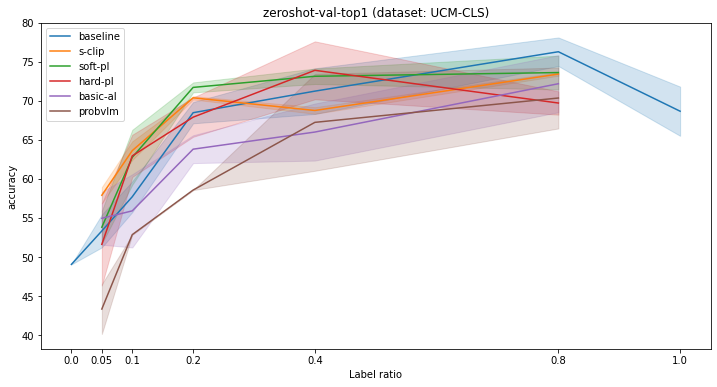

WHU-RS19 zeroshot-val-top1
baseline zeroshot-val-top1 WHU-RS19


method AL.iter    PL  bs             metric   dataset epochs ratio  \
                                                                          
2612   base     NaN  None  64  zeroshot-val-top1  WHU-RS19      0  0.00   
2702   base     NaN  None  64  zeroshot-val-top1  WHU-RS19     25  0.05   
2703   base     NaN  None  64  zeroshot-val-top1  WHU-RS19     25  0.10   
2704   base     NaN  None  64  zeroshot-val-top1  WHU-RS19     25  0.20   
2705   base     NaN  None  64  zeroshot-val-top1  WHU-RS19     25  0.40   
2706   base     NaN  None  64  zeroshot-val-top1  WHU-RS19     25  0.80   
2707   base     NaN  None  64  zeroshot-val-top1  WHU-RS19     25  1.00   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
2612   False  0.00005       0.0  68.560  0.000000     3   
2702   False  0.00005      25.0  72.816  2.298027     5   
2703   False  0.00005      25.0  81.810  1.640290     5   
2704   False  0.00005      25.0  86.944  2.460961     5   
2705   False  0.00005      25.0  93.252  0.540759     5   
2706   False  0.00005      25.0  94.926  0.692120     5   
2707   False  0.00005      25.0  93.032  0.500520     5   

                                           
                                      all  
2612                [68.56, 68.56, 68.56]  
2702  [74.23, 75.72, 71.44, 72.84, 69.85]  
2703   [83.28, 82.39, 79.0, 81.99, 82.39]  
2704  [85.07, 87.86, 90.05, 83.88, 87.86]  
2705  [92.34, 93.73, 93.43, 93.23, 93.53]  
2706  [94.73, 94.93, 95.22, 95.82, 93.93]  
2707  [92.14, 93.23, 93.33, 93.23, 93.23]

s-clip zeroshot-val-top1 WHU-RS19


method AL.iter        PL   bs             metric   dataset epochs ratio  \
                                                                               
8711   ours     NaN  ot.image  128  zeroshot-val-top1  WHU-RS19     25  0.05   
8712   ours     NaN  ot.image  128  zeroshot-val-top1  WHU-RS19     25  0.10   
8713   ours     NaN  ot.image  128  zeroshot-val-top1  WHU-RS19     25  0.20   
8714   ours     NaN  ot.image  128  zeroshot-val-top1  WHU-RS19     25  0.40   
8715   ours     NaN  ot.image  128  zeroshot-val-top1  WHU-RS19     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
8711   False  0.00005      25.0  76.776  1.231109     5   
8712   False  0.00005      25.0  84.932  0.979398     5   
8713   False  0.00005      25.0  87.784  2.714587     5   
8714   False  0.00005      25.0  95.780  0.134164     5   
8715   False  0.00005      25.0  96.678  0.353299     5   

                                           
                                      all  
8711  [75.92, 78.71, 75.92, 76.02, 77.31]  
8712  [85.37, 83.18, 85.37, 85.37, 85.37]  
8713  [86.57, 92.64, 86.57, 86.57, 86.57]  
8714  [95.72, 96.02, 95.72, 95.72, 95.72]  
8715  [96.52, 97.31, 96.52, 96.52, 96.52]

soft-pl zeroshot-val-top1 WHU-RS19


method AL.iter         PL  bs             metric   dataset epochs ratio  \
                                                                                
12311   ours     NaN  soft.text  64  zeroshot-val-top1  WHU-RS19     30  0.05   
12312   ours     NaN  soft.text  64  zeroshot-val-top1  WHU-RS19     30  0.10   
12313   ours     NaN  soft.text  64  zeroshot-val-top1  WHU-RS19     30  0.20   
12314   ours     NaN  soft.text  64  zeroshot-val-top1  WHU-RS19     30  0.40   
12315   ours     NaN  soft.text  64  zeroshot-val-top1  WHU-RS19     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
12311   False  0.00005      30.0  77.570  1.490822     5   
12312   False  0.00005      30.0  83.282  3.577467     5   
12313   False  0.00005      30.0  91.882  1.660548     5   
12314   False  0.00005      30.0  95.680  0.313050     5   
12315   False  0.00005      30.0  96.734  0.760809     5   

                                            
                                       all  
12311   [77.81, 75.12, 77.91, 77.81, 79.2]  
12312    [86.27, 85.07, 79.4, 79.4, 86.27]  
12313  [92.44, 93.13, 88.96, 92.44, 92.44]  
12314  [95.82, 95.12, 95.82, 95.82, 95.82]  
12315  [95.92, 97.41, 97.41, 97.01, 95.92]

hard-pl zeroshot-val-top1 WHU-RS19


method AL.iter         PL  bs             metric   dataset epochs ratio  \
                                                                               
5711   ours     NaN  hard.text  64  zeroshot-val-top1  WHU-RS19     25  0.05   
5712   ours     NaN  hard.text  64  zeroshot-val-top1  WHU-RS19     25  0.10   
5713   ours     NaN  hard.text  64  zeroshot-val-top1  WHU-RS19     25  0.20   
5714   ours     NaN  hard.text  64  zeroshot-val-top1  WHU-RS19     25  0.40   
5715   ours     NaN  hard.text  64  zeroshot-val-top1  WHU-RS19     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
5711   False  0.00005      25.0  76.616  3.076244     5   
5712   False  0.00005      25.0  84.160  1.241813     5   
5713   False  0.00005      25.0  91.182  1.490107     5   
5714   False  0.00005      25.0  93.534  0.952119     5   
5715   False  0.00005      25.0  97.134  1.287975     5   

                                                         
                                                    all  
5711  [75.02, 72.74, 79.8, 75.82, 79.7, 79.8, 71.64,...  
5712  [84.28, 85.37, 82.89, 85.37, 82.89, 84.28, 85....  
5713  [93.03, 88.86, 91.34, 91.34, 91.34, 91.34, 91....  
5714         [92.94, 94.53, 93.23, 92.44, 94.53, 93.63]  
5715  [97.71, 94.83, 97.71, 97.71, 97.71, 97.71, 94....

basic-al zeroshot-val-top1 WHU-RS19


method AL.iter    PL  bs             metric   dataset epochs ratio  \
                                                                         
47    base     2.0  None  64  zeroshot-val-top1  WHU-RS19     20  0.05   
95    base     5.0  None  64  zeroshot-val-top1  WHU-RS19     20  0.10   
143   base    10.0  None  64  zeroshot-val-top1  WHU-RS19     20  0.20   
191   base    20.0  None  64  zeroshot-val-top1  WHU-RS19     20  0.40   
239   base    40.0  None  64  zeroshot-val-top1  WHU-RS19     20  0.80   

    ProbVLM       lr AL.epochs   value                  \
                                  mean       std count   
47    False  0.00005      10.0  57.352  4.002408     5   
95    False  0.00005      10.0  70.686  2.133209     5   
143   False  0.00005      10.0  79.364  3.575735     5   
191   False  0.00005      10.0  84.456  0.925651     5   
239   False  0.00005      10.0  88.776  1.254285     5   

                                          
                                     all  
47    [55.52, 54.13, 63.18, 54.13, 59.8]  
95   [71.64, 71.64, 71.64, 66.87, 71.64]  
143  [76.82, 76.82, 83.28, 76.62, 83.28]  
191  [83.78, 83.78, 85.47, 85.47, 83.78]  
239  [87.86, 87.86, 90.15, 90.15, 87.86]

probvlm zeroshot-val-top1 WHU-RS19


method AL.iter    PL  bs             metric   dataset epochs ratio  \
                                                                         
23    base     2.0  None  32  zeroshot-val-top1  WHU-RS19     25  0.05   
71    base     5.0  None  32  zeroshot-val-top1  WHU-RS19     25  0.10   
119   base    10.0  None  32  zeroshot-val-top1  WHU-RS19     25  0.20   
167   base    20.0  None  32  zeroshot-val-top1  WHU-RS19     25  0.40   
215   base    40.0  None  32  zeroshot-val-top1  WHU-RS19     25  0.80   

    ProbVLM       lr AL.epochs    value                  \
                                   mean       std count   
23     True  0.00005      10.0  55.4260  3.340686     5   
71     True  0.00005      10.0  68.1600  0.000000     5   
119    True  0.00005      10.0  74.4300  0.000000     5   
167    True  0.00005      10.0  88.1400  3.664451     5   
215    True  0.00005      10.0  90.7975  3.487868     4   

                                          
                                     all  
23   [56.92, 49.45, 56.92, 56.92, 56.92]  
71   [68.16, 68.16, 68.16, 68.16, 68.16]  
119  [74.43, 74.43, 74.43, 74.43, 74.43]  
167  [90.75, 90.75, 90.75, 83.08, 85.37]  
215         [92.64, 92.64, 92.34, 85.57]

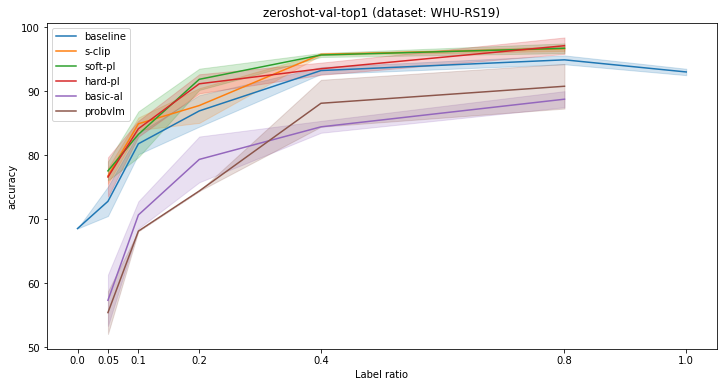

RSSCN7 zeroshot-val-top1
baseline zeroshot-val-top1 RSSCN7


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
2404   base     NaN  None  64  zeroshot-val-top1  RSSCN7      0  0.00   False   
2494   base     NaN  None  64  zeroshot-val-top1  RSSCN7     25  0.05   False   
2495   base     NaN  None  64  zeroshot-val-top1  RSSCN7     25  0.10   False   
2496   base     NaN  None  64  zeroshot-val-top1  RSSCN7     25  0.20   False   
2497   base     NaN  None  64  zeroshot-val-top1  RSSCN7     25  0.40   False   
2498   base     NaN  None  64  zeroshot-val-top1  RSSCN7     25  0.80   False   
2499   base     NaN  None  64  zeroshot-val-top1  RSSCN7     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
2404  0.00005       0.0  55.000  0.000000     3   
2494  0.00005      25.0  54.836  1.017561     5   
2495  0.00005      25.0  63.492  3.774284     5   
2496  0.00005      25.0  65.036  1.538597     5   
2497  0.00005      25.0  64.236  2.246526     5   
2498  0.00005      25.0  66.378  3.602835     5   
2499  0.00005      25.0  66.872  1.670500     5   

                                           
                                      all  
2404                   [55.0, 55.0, 55.0]  
2494   [54.82, 56.39, 53.86, 54.0, 55.11]  
2495   [61.89, 66.39, 68.5, 59.61, 61.07]  
2496    [64.04, 65.5, 66.96, 63.0, 65.68]  
2497  [60.71, 63.43, 65.25, 66.43, 65.36]  
2498  [65.64, 61.61, 71.64, 65.82, 67.18]  
2499  [67.43, 67.68, 63.89, 67.68, 67.68]

s-clip zeroshot-val-top1 RSSCN7


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
8461   ours     NaN  ot.image  128  zeroshot-val-top1  RSSCN7     25  0.05   
8462   ours     NaN  ot.image  128  zeroshot-val-top1  RSSCN7     25  0.10   
8463   ours     NaN  ot.image  128  zeroshot-val-top1  RSSCN7     25  0.20   
8464   ours     NaN  ot.image  128  zeroshot-val-top1  RSSCN7     25  0.40   
8465   ours     NaN  ot.image  128  zeroshot-val-top1  RSSCN7     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
8461   False  0.00005      25.0  57.146  3.059490     5   
8462   False  0.00005      25.0  59.454  0.143108     5   
8463   False  0.00005      25.0  66.004  3.049997     5   
8464   False  0.00005      25.0  59.682  2.173458     5   
8465   False  0.00005      25.0  66.902  0.465102     5   

                                           
                                      all  
8461  [58.71, 57.89, 58.71, 58.71, 51.71]  
8462  [59.39, 59.71, 59.39, 59.39, 59.39]  
8463  [64.64, 71.46, 64.64, 64.64, 64.64]  
8464  [58.71, 63.57, 58.71, 58.71, 58.71]  
8465  [67.11, 66.07, 67.11, 67.11, 67.11]

soft-pl zeroshot-val-top1 RSSCN7


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                              
12011   ours     NaN  soft.text  64  zeroshot-val-top1  RSSCN7     30  0.05   
12012   ours     NaN  soft.text  64  zeroshot-val-top1  RSSCN7     30  0.10   
12013   ours     NaN  soft.text  64  zeroshot-val-top1  RSSCN7     30  0.20   
12014   ours     NaN  soft.text  64  zeroshot-val-top1  RSSCN7     30  0.40   
12015   ours     NaN  soft.text  64  zeroshot-val-top1  RSSCN7     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
12011   False  0.00005      30.0  58.644  4.783020     5   
12012   False  0.00005      30.0  62.436  1.606200     5   
12013   False  0.00005      30.0  65.830  2.353657     5   
12014   False  0.00005      30.0  67.864  1.889704     5   
12015   False  0.00005      30.0  64.800  2.345666     5   

                                            
                                       all  
12011  [63.75, 55.75, 56.29, 63.79, 53.64]  
12012  [63.61, 59.71, 62.61, 62.61, 63.64]  
12013  [66.36, 61.86, 68.18, 66.36, 66.39]  
12014  [69.93, 66.68, 66.39, 66.39, 69.93]  
12015  [64.61, 61.32, 65.64, 67.82, 64.61]

hard-pl zeroshot-val-top1 RSSCN7


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
5461   ours     NaN  hard.text  64  zeroshot-val-top1  RSSCN7     25  0.05   
5462   ours     NaN  hard.text  64  zeroshot-val-top1  RSSCN7     25  0.10   
5463   ours     NaN  hard.text  64  zeroshot-val-top1  RSSCN7     25  0.20   
5464   ours     NaN  hard.text  64  zeroshot-val-top1  RSSCN7     25  0.40   
5465   ours     NaN  hard.text  64  zeroshot-val-top1  RSSCN7     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
5461   False  0.00005      25.0  56.786  3.571733     5   
5462   False  0.00005      25.0  58.944  1.496489     5   
5463   False  0.00005      25.0  64.956  3.422306     5   
5464   False  0.00005      25.0  66.790  1.980795     5   
5465   False  0.00005      25.0  64.002  0.720014     5   

                                                         
                                                    all  
5461  [52.93, 53.29, 60.21, 57.25, 60.25, 60.21, 58....  
5462  [60.36, 57.32, 59.86, 57.32, 59.86, 60.36, 57....  
5463  [59.14, 67.21, 64.57, 66.93, 66.93, 66.93, 64....  
5464           [67.0, 68.71, 64.57, 64.96, 68.71, 62.0]  
5465  [63.68, 65.29, 63.68, 63.68, 63.68, 67.07, 65....

basic-al zeroshot-val-top1 RSSCN7


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
45    base     2.0  None  64  zeroshot-val-top1  RSSCN7     20  0.05   False   
93    base     5.0  None  64  zeroshot-val-top1  RSSCN7     20  0.10   False   
141   base    10.0  None  64  zeroshot-val-top1  RSSCN7     20  0.20   False   
189   base    20.0  None  64  zeroshot-val-top1  RSSCN7     20  0.40   False   
237   base    40.0  None  64  zeroshot-val-top1  RSSCN7     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
45   0.00005      10.0  51.362  1.423032     5   
93   0.00005      10.0  62.174  2.590652     5   
141  0.00005      10.0  61.194  2.826974     5   
189  0.00005      10.0  57.972  1.330966     5   
237  0.00005      10.0  60.122  3.247995     5   

                                          
                                     all  
45   [51.21, 51.64, 53.14, 51.64, 49.18]  
93   [63.32, 63.36, 63.36, 57.54, 63.29]  
141  [62.57, 62.54, 62.36, 56.14, 62.36]  
189     [57.0, 57.0, 59.43, 59.43, 57.0]  
237  [57.75, 57.75, 63.68, 63.68, 57.75]

probvlm zeroshot-val-top1 RSSCN7


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
21    base     2.0  None  32  zeroshot-val-top1  RSSCN7     25  0.05    True   
69    base     5.0  None  32  zeroshot-val-top1  RSSCN7     25  0.10    True   
117   base    10.0  None  32  zeroshot-val-top1  RSSCN7     25  0.20    True   
165   base    20.0  None  32  zeroshot-val-top1  RSSCN7     25  0.40    True   
213   base    40.0  None  32  zeroshot-val-top1  RSSCN7     25  0.80    True   

          lr AL.epochs   value                  \
                          mean       std count   
21   0.00005      10.0  44.728  2.186874     5   
69   0.00005      10.0  53.000  0.000000     5   
117  0.00005      10.0  58.640  0.000000     5   
165  0.00005      10.0  56.884  1.110892     5   
213  0.00005      10.0  62.080  3.628875     4   

                                          
                                     all  
21   [43.75, 48.64, 43.75, 43.75, 43.75]  
69        [53.0, 53.0, 53.0, 53.0, 53.0]  
117  [58.64, 58.64, 58.64, 58.64, 58.64]  
165  [57.64, 57.64, 57.64, 56.32, 55.18]  
213         [62.57, 66.68, 61.14, 57.93]

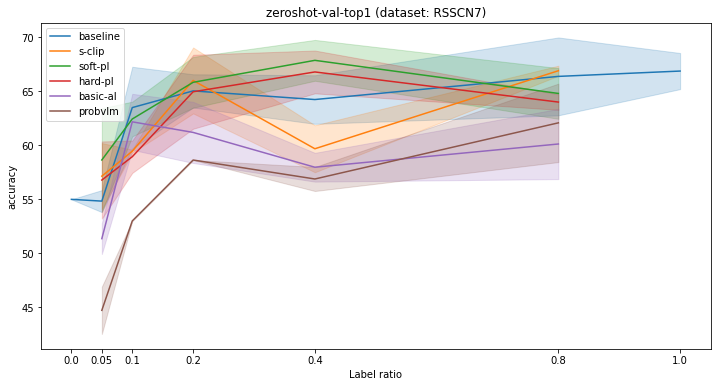

AID zeroshot-val-top1
baseline zeroshot-val-top1 AID


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
2094   base     NaN  None  64  zeroshot-val-top1     AID      0  0.00   False   
2183   base     NaN  None  64  zeroshot-val-top1     AID     25  0.05   False   
2184   base     NaN  None  64  zeroshot-val-top1     AID     25  0.10   False   
2185   base     NaN  None  64  zeroshot-val-top1     AID     25  0.20   False   
2186   base     NaN  None  64  zeroshot-val-top1     AID     25  0.40   False   
2187   base     NaN  None  64  zeroshot-val-top1     AID     25  0.80   False   
2188   base     NaN  None  64  zeroshot-val-top1     AID     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
2094  0.00005       0.0  52.820  0.000000     2   
2183  0.00005      25.0  61.106  2.422329     5   
2184  0.00005      25.0  68.166  1.051038     5   
2185  0.00005      25.0  77.632  1.239706     5   
2186  0.00005      25.0  86.402  1.271739     5   
2187  0.00005      25.0  89.808  0.570500     5   
2188  0.00005      25.0  87.698  2.225774     5   

                                           
                                      all  
2094                       [52.82, 52.82]  
2183  [63.22, 63.72, 59.32, 61.16, 58.11]  
2184   [68.61, 69.48, 68.18, 67.96, 66.6]  
2185  [76.31, 77.42, 79.66, 77.14, 77.63]  
2186    [87.16, 86.7, 85.3, 87.94, 84.91]  
2187   [89.99, 89.19, 89.9, 90.62, 89.34]  
2188   [90.82, 86.13, 89.31, 86.13, 86.1]

s-clip zeroshot-val-top1 AID


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
8086   ours     NaN  ot.image  128  zeroshot-val-top1     AID     25  0.05   
8087   ours     NaN  ot.image  128  zeroshot-val-top1     AID     25  0.10   
8088   ours     NaN  ot.image  128  zeroshot-val-top1     AID     25  0.20   
8089   ours     NaN  ot.image  128  zeroshot-val-top1     AID     25  0.40   
8090   ours     NaN  ot.image  128  zeroshot-val-top1     AID     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
8086   False  0.00005      25.0  60.780  1.260674     5   
8087   False  0.00005      25.0  71.688  0.764735     5   
8088   False  0.00005      25.0  81.980  0.201246     5   
8089   False  0.00005      25.0  90.080  0.916788     5   
8090   False  0.00005      25.0  91.262  0.152053     5   

                                           
                                      all  
8086   [59.89, 61.63, 59.89, 59.9, 62.59]  
8087  [72.03, 70.32, 72.03, 72.03, 72.03]  
8088  [81.89, 82.34, 81.89, 81.89, 81.89]  
8089  [90.49, 88.44, 90.49, 90.49, 90.49]  
8090  [91.33, 90.99, 91.33, 91.33, 91.33]

soft-pl zeroshot-val-top1 AID


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                              
11561   ours     NaN  soft.text  64  zeroshot-val-top1     AID     30  0.05   
11562   ours     NaN  soft.text  64  zeroshot-val-top1     AID     30  0.10   
11563   ours     NaN  soft.text  64  zeroshot-val-top1     AID     30  0.20   
11564   ours     NaN  soft.text  64  zeroshot-val-top1     AID     30  0.40   
11565   ours     NaN  soft.text  64  zeroshot-val-top1     AID     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
11561   False  0.00005      30.0  61.662  1.410805     5   
11562   False  0.00005      30.0  71.476  1.230114     5   
11563   False  0.00005      30.0  83.206  0.878282     5   
11564   False  0.00005      30.0  88.418  1.586591     5   
11565   False  0.00005      30.0  92.858  0.868372     5   

                                            
                                       all  
11561  [63.01, 59.65, 61.24, 63.02, 61.39]  
11562  [71.66, 73.33, 70.35, 70.35, 71.69]  
11563   [83.18, 84.5, 82.02, 83.18, 83.15]  
11564  [86.68, 89.59, 89.57, 89.57, 86.68]  
11565  [92.31, 93.63, 92.08, 93.96, 92.31]

hard-pl zeroshot-val-top1 AID


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
5086   ours     NaN  hard.text  64  zeroshot-val-top1     AID     25  0.05   
5087   ours     NaN  hard.text  64  zeroshot-val-top1     AID     25  0.10   
5088   ours     NaN  hard.text  64  zeroshot-val-top1     AID     25  0.20   
5089   ours     NaN  hard.text  64  zeroshot-val-top1     AID     25  0.40   
5090   ours     NaN  hard.text  64  zeroshot-val-top1     AID     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
5086   False  0.00005      25.0  62.148  1.000335     5   
5087   False  0.00005      25.0  71.790  0.514296     5   
5088   False  0.00005      25.0  81.180  0.213307     5   
5089   False  0.00005      25.0  87.206  1.901534     5   
5090   False  0.00005      25.0  90.238  0.787096     5   

                                                         
                                                    all  
5086  [60.54, 62.08, 62.43, 63.27, 62.42, 62.43, 57....  
5087  [72.67, 71.72, 71.42, 71.72, 71.42, 72.67, 71....  
5088  [81.49, 80.94, 81.29, 81.09, 81.09, 81.09, 81....  
5089         [89.71, 87.66, 84.51, 86.49, 87.66, 87.62]  
5090  [90.59, 88.83, 90.59, 90.59, 90.59, 91.72, 88....

basic-al zeroshot-val-top1 AID


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
42    base     2.0  None  64  zeroshot-val-top1     AID     20  0.05   False   
90    base     5.0  None  64  zeroshot-val-top1     AID     20  0.10   False   
138   base    10.0  None  64  zeroshot-val-top1     AID     20  0.20   False   
186   base    20.0  None  64  zeroshot-val-top1     AID     20  0.40   False   
234   base    40.0  None  64  zeroshot-val-top1     AID     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
42   0.00005      10.0  41.808  3.546022     5   
90   0.00005      10.0  58.554  4.111032     5   
138  0.00005      10.0  65.626  5.568454     5   
186  0.00005      10.0  75.212  5.137638     5   
234  0.00005      10.0  81.850  1.177603     5   

                                          
                                     all  
42    [41.92, 38.25, 45.7, 38.24, 44.93]  
90     [60.38, 60.41, 60.38, 51.2, 60.4]  
138  [62.26, 62.28, 71.66, 60.27, 71.66]  
186  [71.46, 71.46, 80.84, 80.84, 71.46]  
234  [80.99, 80.99, 83.14, 83.14, 80.99]

probvlm zeroshot-val-top1 AID


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
18    base     2.0  None  32  zeroshot-val-top1     AID     25  0.05    True   
66    base     5.0  None  32  zeroshot-val-top1     AID     25  0.10    True   
114   base    10.0  None  32  zeroshot-val-top1     AID     25  0.20    True   
162   base    20.0  None  32  zeroshot-val-top1     AID     25  0.40    True   
210   base    40.0  None  32  zeroshot-val-top1     AID     25  0.80    True   

          lr AL.epochs   value                  \
                          mean       std count   
18   0.00005      10.0  40.574  2.294206     5   
66   0.00005      10.0  57.000  0.000000     5   
114  0.00005      10.0  66.170  0.000000     5   
162  0.00005      10.0  77.952  4.788661     5   
210  0.00005      10.0  85.175  1.634187     4   

                                          
                                     all  
18       [41.6, 36.47, 41.6, 41.6, 41.6]  
66        [57.0, 57.0, 57.0, 57.0, 57.0]  
114  [66.17, 66.17, 66.17, 66.17, 66.17]  
162  [81.38, 81.38, 81.38, 74.15, 71.47]  
210         [84.69, 85.04, 87.43, 83.54]

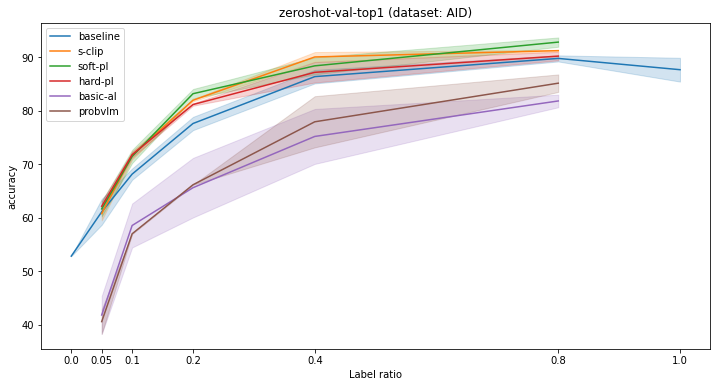

RESISC45 zeroshot-val-top1
baseline zeroshot-val-top1 RESISC45


method AL.iter    PL  bs             metric   dataset epochs ratio  \
                                                                          
2197   base     NaN  None  64  zeroshot-val-top1  RESISC45      0  0.00   
2286   base     NaN  None  64  zeroshot-val-top1  RESISC45     25  0.05   
2287   base     NaN  None  64  zeroshot-val-top1  RESISC45     25  0.10   
2288   base     NaN  None  64  zeroshot-val-top1  RESISC45     25  0.20   
2289   base     NaN  None  64  zeroshot-val-top1  RESISC45     25  0.40   
2290   base     NaN  None  64  zeroshot-val-top1  RESISC45     25  0.80   
2291   base     NaN  None  64  zeroshot-val-top1  RESISC45     25  1.00   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
2197   False  0.00005       0.0  48.710  0.000000     2   
2286   False  0.00005      25.0  31.408  1.490493     5   
2287   False  0.00005      25.0  32.692  1.019348     5   
2288   False  0.00005      25.0  38.208  1.053931     5   
2289   False  0.00005      25.0  40.236  1.704503     5   
2290   False  0.00005      25.0  43.876  1.197969     5   
2291   False  0.00005      25.0  45.844  0.564385     5   

                                           
                                      all  
2197                       [48.71, 48.71]  
2286  [30.12, 32.15, 32.16, 33.05, 29.56]  
2287   [34.33, 32.2, 31.73, 32.98, 32.22]  
2288   [38.8, 38.18, 36.42, 39.09, 38.55]  
2289   [43.16, 39.87, 39.38, 40.0, 38.77]  
2290  [45.67, 42.86, 42.78, 44.38, 43.69]  
2291  [46.71, 45.46, 46.13, 45.46, 45.46]

s-clip zeroshot-val-top1 RESISC45


method AL.iter        PL   bs             metric   dataset epochs ratio  \
                                                                               
8211   ours     NaN  ot.image  128  zeroshot-val-top1  RESISC45     25  0.05   
8212   ours     NaN  ot.image  128  zeroshot-val-top1  RESISC45     25  0.10   
8213   ours     NaN  ot.image  128  zeroshot-val-top1  RESISC45     25  0.20   
8214   ours     NaN  ot.image  128  zeroshot-val-top1  RESISC45     25  0.40   
8215   ours     NaN  ot.image  128  zeroshot-val-top1  RESISC45     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
8211   False  0.00005      25.0  31.670  0.645794     5   
8212   False  0.00005      25.0  35.382  0.643988     5   
8213   False  0.00005      25.0  42.808  1.748605     5   
8214   False  0.00005      25.0  46.538  0.040249     5   
8215   False  0.00005      25.0  49.022  1.957682     5   

                                           
                                      all  
8211   [31.71, 30.7, 31.71, 31.71, 32.52]  
8212  [35.67, 34.23, 35.67, 35.67, 35.67]  
8213  [43.59, 39.68, 43.59, 43.59, 43.59]  
8214  [46.52, 46.61, 46.52, 46.52, 46.52]  
8215     [49.9, 45.52, 49.9, 49.9, 49.89]

soft-pl zeroshot-val-top1 RESISC45


method AL.iter         PL  bs             metric   dataset epochs ratio  \
                                                                                
11711   ours     NaN  soft.text  64  zeroshot-val-top1  RESISC45     30  0.05   
11712   ours     NaN  soft.text  64  zeroshot-val-top1  RESISC45     30  0.10   
11713   ours     NaN  soft.text  64  zeroshot-val-top1  RESISC45     30  0.20   
11714   ours     NaN  soft.text  64  zeroshot-val-top1  RESISC45     30  0.40   
11715   ours     NaN  soft.text  64  zeroshot-val-top1  RESISC45     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
11711   False  0.00005      30.0  30.328  1.330233     5   
11712   False  0.00005      30.0  36.942  2.449514     5   
11713   False  0.00005      30.0  44.372  1.224978     5   
11714   False  0.00005      30.0  45.820  1.336095     5   
11715   False  0.00005      30.0  46.714  2.242338     5   

                                            
                                       all  
11711  [31.34, 28.54, 29.26, 31.34, 31.16]  
11712  [34.26, 39.09, 38.54, 38.54, 34.28]  
11713  [45.06, 44.46, 42.23, 45.06, 45.05]  
11714  [44.36, 46.64, 46.87, 46.87, 44.36]  
11715   [44.62, 46.4, 48.22, 49.71, 44.62]

hard-pl zeroshot-val-top1 RESISC45


method AL.iter         PL  bs             metric   dataset epochs ratio  \
                                                                               
5211   ours     NaN  hard.text  64  zeroshot-val-top1  RESISC45     25  0.05   
5212   ours     NaN  hard.text  64  zeroshot-val-top1  RESISC45     25  0.10   
5213   ours     NaN  hard.text  64  zeroshot-val-top1  RESISC45     25  0.20   
5214   ours     NaN  hard.text  64  zeroshot-val-top1  RESISC45     25  0.40   
5215   ours     NaN  hard.text  64  zeroshot-val-top1  RESISC45     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
5211   False  0.00005      25.0  29.532  1.536219     5   
5212   False  0.00005      25.0  35.312  0.492818     5   
5213   False  0.00005      25.0  40.044  1.627108     5   
5214   False  0.00005      25.0  44.900  1.230406     5   
5215   False  0.00005      25.0  45.998  0.375659     5   

                                                         
                                                    all  
5211  [27.85, 28.36, 29.83, 31.78, 29.84, 29.83, 28....  
5212  [34.74, 35.08, 35.83, 35.08, 35.83, 34.74, 35....  
5213  [37.36, 39.84, 41.62, 40.7, 40.7, 40.7, 41.62,...  
5214         [47.02, 44.43, 44.77, 43.85, 44.43, 45.78]  
5215  [45.83, 46.67, 45.83, 45.83, 45.83, 46.49, 46....

basic-al zeroshot-val-top1 RESISC45


method AL.iter    PL  bs             metric   dataset epochs ratio  \
                                                                         
43    base     2.0  None  64  zeroshot-val-top1  RESISC45     20  0.05   
91    base     5.0  None  64  zeroshot-val-top1  RESISC45     20  0.10   
139   base    10.0  None  64  zeroshot-val-top1  RESISC45     20  0.20   
187   base    20.0  None  64  zeroshot-val-top1  RESISC45     20  0.40   
235   base    40.0  None  64  zeroshot-val-top1  RESISC45     20  0.80   

    ProbVLM       lr AL.epochs   value                  \
                                  mean       std count   
43    False  0.00005      10.0  22.062  2.054062     5   
91    False  0.00005      10.0  28.878  0.493072     5   
139   False  0.00005      10.0  32.034  3.995263     5   
187   False  0.00005      10.0  36.426  2.322344     5   
235   False  0.00005      10.0  39.226  0.432701     5   

                                          
                                     all  
43    [22.2, 19.97, 24.05, 19.98, 24.11]  
91   [28.66, 28.66, 28.65, 29.76, 28.66]  
139  [31.27, 31.29, 35.76, 26.11, 35.74]  
187  [34.73, 34.73, 38.97, 38.97, 34.73]  
235    [38.91, 38.91, 39.7, 39.7, 38.91]

probvlm zeroshot-val-top1 RESISC45


method AL.iter    PL  bs             metric   dataset epochs ratio  \
                                                                         
19    base     2.0  None  32  zeroshot-val-top1  RESISC45     25  0.05   
67    base     5.0  None  32  zeroshot-val-top1  RESISC45     25  0.10   
115   base    10.0  None  32  zeroshot-val-top1  RESISC45     25  0.20   
163   base    20.0  None  32  zeroshot-val-top1  RESISC45     25  0.40   
211   base    40.0  None  32  zeroshot-val-top1  RESISC45     25  0.80   

    ProbVLM       lr AL.epochs    value                      \
                                   mean           std count   
19     True  0.00005      10.0  21.3220  2.504396e-01     5   
67     True  0.00005      10.0  27.0300  0.000000e+00     5   
115    True  0.00005      10.0  27.1900  3.972055e-15     5   
163    True  0.00005      10.0  33.7480  2.435061e+00     5   
211    True  0.00005      10.0  37.7925  4.364633e+00     4   

                                          
                                     all  
19   [21.21, 21.77, 21.21, 21.21, 21.21]  
67   [27.03, 27.03, 27.03, 27.03, 27.03]  
115  [27.19, 27.19, 27.19, 27.19, 27.19]  
163   [32.55, 32.55, 32.55, 38.09, 33.0]  
211         [42.77, 39.83, 35.63, 32.94]

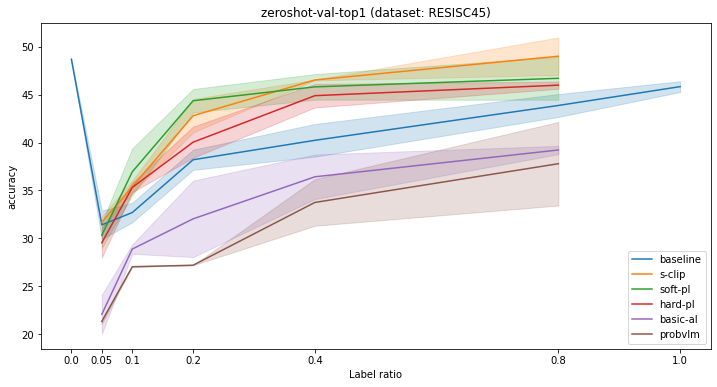

In [19]:
metric = 'zeroshot-val-top1'
datasets = ["RSICD-CLS", "UCM-CLS", "WHU-RS19", "RSSCN7", "AID", "RESISC45"]
for dataset in datasets:
    print(dataset, metric)
    plot_model_comparison(results_dict, metric, dataset)

baseline text_to_image_R@5 RSICD


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
1785   base     NaN  None  64  text_to_image_R@5   RSICD      0  0.00   False   
1874   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.05   False   
1875   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.10   False   
1876   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.20   False   
1877   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.40   False   
1878   base     NaN  None  64  text_to_image_R@5   RSICD     25  0.80   False   
1879   base     NaN  None  64  text_to_image_R@5   RSICD     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
1785  0.00005       0.0  14.270  0.000000     2   
1874  0.00005      25.0  13.122  0.420678     5   
1875  0.00005      25.0  16.690  0.939920     5   
1876  0.00005      25.0  20.806  1.018052     5   
1877  0.00005      25.0  24.904  0.638968     5   
1878  0.00005      25.0  29.532  0.979525     5   
1879  0.00005      25.0  31.070  1.026913     5   

                                           
                                      all  
1785                       [14.27, 14.27]  
1874  [13.27, 13.54, 12.72, 12.63, 13.45]  
1875  [15.65, 18.12, 16.47, 16.19, 17.02]  
1876  [20.31, 19.67, 22.42, 20.77, 20.86]  
1877  [24.15, 24.61, 25.89, 24.89, 24.98]  
1878  [28.45, 30.92, 28.82, 29.46, 30.01]  
1879  [30.19, 30.74, 32.85, 30.74, 30.83]

s-clip text_to_image_R@5 RSICD


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
7711   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.05   
7712   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.10   
7713   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.20   
7714   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.40   
7715   ours     NaN  ot.image  128  text_to_image_R@5   RSICD     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
7711   False  0.00005      25.0  13.924  0.474847     5   
7712   False  0.00005      25.0  17.196  0.818401     5   
7713   False  0.00005      25.0  19.978  0.286217     5   
7714   False  0.00005      25.0  23.462  0.898899     5   
7715   False  0.00005      25.0  28.968  0.733430     5   

                                           
                                      all  
7711  [14.27, 13.45, 14.27, 14.27, 13.36]  
7712  [16.83, 18.66, 16.83, 16.83, 16.83]  
7713  [19.85, 20.49, 19.85, 19.85, 19.85]  
7714  [23.06, 25.07, 23.06, 23.06, 23.06]  
7715  [28.64, 30.28, 28.64, 28.64, 28.64]

soft-pl text_to_image_R@5 RSICD


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                              
11111   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.05   
11112   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.10   
11113   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.20   
11114   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.40   
11115   ours     NaN  soft.text  64  text_to_image_R@5   RSICD     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
11111   False  0.00005      30.0  14.638  0.614549     5   
11112   False  0.00005      30.0  18.152  0.697653     5   
11113   False  0.00005      30.0  22.234  1.206764     5   
11114   False  0.00005      30.0  25.712  0.497112     5   
11115   False  0.00005      30.0  30.062  1.053551     5   

                                            
                                       all  
11111  [14.73, 13.63, 14.91, 14.64, 15.28]  
11112   [17.84, 19.4, 17.84, 17.84, 17.84]  
11113   [23.06, 21.59, 20.4, 23.06, 23.06]  
11114  [26.26, 24.98, 25.62, 25.62, 26.08]  
11115  [28.91, 30.83, 30.74, 30.92, 28.91]

hard-pl text_to_image_R@5 RSICD


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
4711   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.05   
4712   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.10   
4713   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.20   
4714   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.40   
4715   ours     NaN  hard.text  64  text_to_image_R@5   RSICD     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
4711   False  0.00005      25.0  13.630  0.606795     5   
4712   False  0.00005      25.0  17.988  1.053812     5   
4713   False  0.00005      25.0  20.258  0.612021     5   
4714   False  0.00005      25.0  25.616  0.849723     5   
4715   False  0.00005      25.0  30.248  0.532184     5   

                                                         
                                                    all  
4711  [12.99, 13.45, 14.27, 13.17, 14.27, 14.27, 13....  
4712  [16.38, 17.84, 18.94, 17.84, 18.94, 16.38, 17....  
4713  [19.21, 20.68, 20.22, 20.59, 20.59, 20.59, 20....  
4714          [24.79, 26.44, 25.71, 24.7, 26.44, 26.35]  
4715  [30.01, 31.2, 30.01, 30.01, 30.01, 30.28, 31.2...

basic-al text_to_image_R@5 RSICD


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
39    base     2.0  None  64  text_to_image_R@5   RSICD     20  0.05   False   
87    base     5.0  None  64  text_to_image_R@5   RSICD     20  0.10   False   
135   base    10.0  None  64  text_to_image_R@5   RSICD     20  0.20   False   
183   base    20.0  None  64  text_to_image_R@5   RSICD     20  0.40   False   
231   base    40.0  None  64  text_to_image_R@5   RSICD     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
39   0.00005      10.0   8.324  1.836608     5   
87   0.00005      10.0  12.422  0.075299     5   
135  0.00005      10.0  15.830  1.833548     5   
183  0.00005      10.0  20.806  1.456942     5   
231  0.00005      10.0  24.210  0.301247     5   

                                          
                                     all  
39       [8.05, 6.86, 11.34, 6.86, 8.51]  
87   [12.44, 12.35, 12.35, 12.53, 12.44]  
135   [16.1, 16.38, 17.02, 12.63, 17.02]  
183  [21.87, 21.87, 19.21, 19.21, 21.87]  
231  [24.43, 24.43, 23.88, 23.88, 24.43]

probvlm text_to_image_R@5 RSICD


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
15    base     2.0  None  32  text_to_image_R@5   RSICD     25  0.05    True   
63    base     5.0  None  32  text_to_image_R@5   RSICD     25  0.10    True   
111   base    10.0  None  32  text_to_image_R@5   RSICD     25  0.20    True   
159   base    20.0  None  32  text_to_image_R@5   RSICD     25  0.40    True   
207   base    40.0  None  32  text_to_image_R@5   RSICD     25  0.80    True   

          lr AL.epochs   value                  \
                          mean       std count   
15   0.00005      10.0   7.760  0.245967     5   
63   0.00005      10.0  12.630  0.000000     5   
111  0.00005      10.0  17.020  0.000000     5   
159  0.00005      10.0  21.082  0.339588     5   
207  0.00005      10.0  24.450  1.321439     4   

                                          
                                     all  
15        [7.87, 7.32, 7.87, 7.87, 7.87]  
63   [12.63, 12.63, 12.63, 12.63, 12.63]  
111  [17.02, 17.02, 17.02, 17.02, 17.02]  
159  [21.32, 21.32, 21.32, 20.59, 20.86]  
207         [23.24, 25.89, 25.25, 23.42]

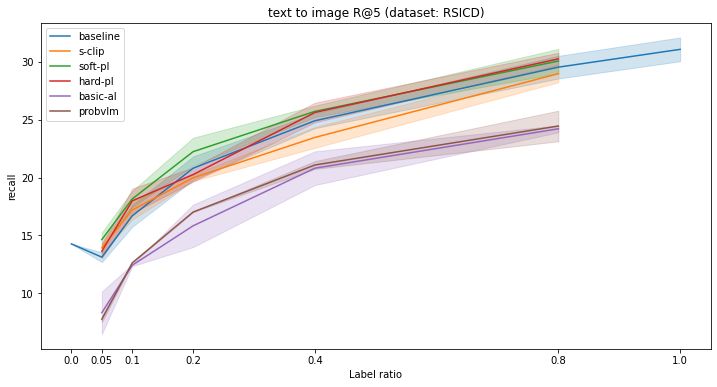

baseline text_to_image_R@5 UCM


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
1991   base     NaN  None  64  text_to_image_R@5     UCM      0  0.00   False   
2080   base     NaN  None  64  text_to_image_R@5     UCM     25  0.05   False   
2081   base     NaN  None  64  text_to_image_R@5     UCM     25  0.10   False   
2082   base     NaN  None  64  text_to_image_R@5     UCM     25  0.20   False   
2083   base     NaN  None  64  text_to_image_R@5     UCM     25  0.40   False   
2084   base     NaN  None  64  text_to_image_R@5     UCM     25  0.80   False   
2085   base     NaN  None  64  text_to_image_R@5     UCM     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
1991  0.00005       0.0  31.430  0.000000     2   
2080  0.00005      25.0  35.142  3.341118     5   
2081  0.00005      25.0  38.096  1.814657     5   
2082  0.00005      25.0  48.666  1.033697     5   
2083  0.00005      25.0  50.666  1.735578     5   
2084  0.00005      25.0  55.334  1.824179     5   
2085  0.00005      25.0  59.714  2.558062     5   

                                           
                                      all  
1991                       [31.43, 31.43]  
2080   [37.14, 36.19, 39.05, 31.9, 31.43]  
2081   [35.71, 40.0, 39.05, 36.67, 39.05]  
2082   [50.0, 48.57, 47.14, 49.05, 48.57]  
2083   [53.33, 50.0, 48.57, 50.95, 50.48]  
2084  [54.29, 54.29, 54.76, 58.57, 54.76]  
2085  [58.57, 61.43, 55.71, 61.43, 61.43]

s-clip text_to_image_R@5 UCM


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
7961   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.05   
7962   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.10   
7963   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.20   
7964   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.40   
7965   ours     NaN  ot.image  128  text_to_image_R@5     UCM     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
7961   False  0.00005      25.0  36.096  1.829393     5   
7962   False  0.00005      25.0  43.140  0.424853     5   
7963   False  0.00005      25.0  52.950  0.849706     5   
7964   False  0.00005      25.0  51.900  0.000000     5   
7965   False  0.00005      25.0  58.854  1.489221     5   

                                           
                                      all  
7961    [34.76, 38.1, 34.76, 34.76, 38.1]  
7962  [43.33, 42.38, 43.33, 43.33, 43.33]  
7963  [53.33, 51.43, 53.33, 53.33, 53.33]  
7964       [51.9, 51.9, 51.9, 51.9, 51.9]  
7965  [59.52, 56.19, 59.52, 59.52, 59.52]

soft-pl text_to_image_R@5 UCM


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                              
11411   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.05   
11412   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.10   
11413   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.20   
11414   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.40   
11415   ours     NaN  soft.text  64  text_to_image_R@5     UCM     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
11411   False  0.00005      30.0  38.192  3.292107     5   
11412   False  0.00005      30.0  42.476  1.362289     5   
11413   False  0.00005      30.0  46.474  0.926974     5   
11414   False  0.00005      30.0  52.188  1.192841     5   
11415   False  0.00005      30.0  57.618  1.431667     5   

                                            
                                       all  
11411  [40.48, 33.33, 36.19, 40.48, 40.48]  
11412  [42.38, 44.76, 41.43, 41.43, 42.38]  
11413  [47.14, 45.71, 45.24, 47.14, 47.14]  
11414    [53.33, 50.48, 51.9, 51.9, 53.33]  
11415  [57.14, 59.05, 55.71, 59.05, 57.14]

hard-pl text_to_image_R@5 UCM


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
4961   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.05   
4962   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.10   
4963   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.20   
4964   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.40   
4965   ours     NaN  hard.text  64  text_to_image_R@5     UCM     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
4961   False  0.00005      25.0  35.430  3.755210     5   
4962   False  0.00005      25.0  43.906  3.390403     5   
4963   False  0.00005      25.0  48.476  3.202246     5   
4964   False  0.00005      25.0  53.998  3.096784     5   
4965   False  0.00005      25.0  59.808  2.553590     5   

                                                         
                                                    all  
4961  [34.29, 35.24, 32.86, 41.9, 32.86, 32.86, 35.2...  
4962  [41.43, 47.62, 41.43, 47.62, 41.43, 41.43, 47....  
4963  [46.19, 50.95, 52.86, 46.19, 46.19, 46.19, 52....  
4964          [58.57, 53.33, 50.0, 54.76, 53.33, 55.24]  
4965  [60.95, 55.24, 60.95, 60.95, 60.95, 56.67, 55....

basic-al text_to_image_R@5 UCM


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
41    base     2.0  None  64  text_to_image_R@5     UCM     20  0.05   False   
89    base     5.0  None  64  text_to_image_R@5     UCM     20  0.10   False   
137   base    10.0  None  64  text_to_image_R@5     UCM     20  0.20   False   
185   base    20.0  None  64  text_to_image_R@5     UCM     20  0.40   False   
233   base    40.0  None  64  text_to_image_R@5     UCM     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
41   0.00005      10.0  33.428  1.915690     5   
89   0.00005      10.0  39.046  1.064368     5   
137  0.00005      10.0  42.856  1.344388     5   
185  0.00005      10.0  48.666  3.127496     5   
233  0.00005      10.0  52.858  1.303580     5   

                                          
                                     all  
41   [35.71, 32.38, 31.43, 32.38, 35.24]  
89   [38.57, 38.57, 38.57, 40.95, 38.57]  
137  [43.33, 43.33, 43.33, 40.48, 43.81]  
185  [50.95, 50.95, 45.24, 45.24, 50.95]  
233  [53.81, 53.81, 51.43, 51.43, 53.81]

probvlm text_to_image_R@5 UCM


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
17    base     2.0  None  32  text_to_image_R@5     UCM     25  0.05    True   
65    base     5.0  None  32  text_to_image_R@5     UCM     25  0.10    True   
113   base    10.0  None  32  text_to_image_R@5     UCM     25  0.20    True   
161   base    20.0  None  32  text_to_image_R@5     UCM     25  0.40    True   
209   base    40.0  None  32  text_to_image_R@5     UCM     25  0.80    True   

          lr AL.epochs    value                  \
                           mean       std count   
17   0.00005      10.0  29.2420  2.768252     5   
65   0.00005      10.0  36.1900  0.000000     5   
113  0.00005      10.0  42.3800  0.000000     5   
161  0.00005      10.0  45.5280  2.768252     5   
209  0.00005      10.0  47.1425  1.944897     4   

                                          
                                     all  
17   [30.48, 24.29, 30.48, 30.48, 30.48]  
65   [36.19, 36.19, 36.19, 36.19, 36.19]  
113  [42.38, 42.38, 42.38, 42.38, 42.38]  
161  [44.29, 44.29, 44.29, 44.29, 50.48]  
209         [48.57, 49.05, 45.71, 45.24]

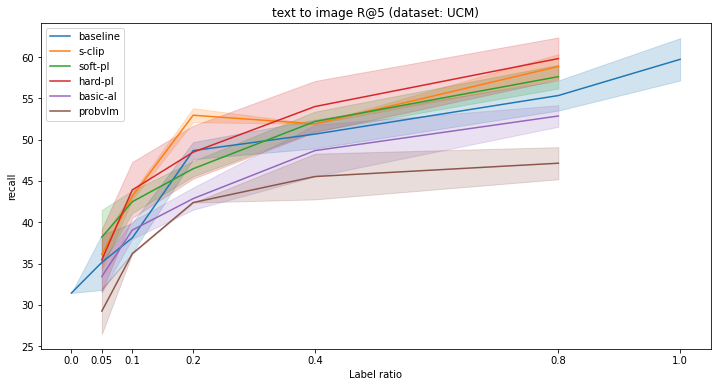

baseline text_to_image_R@5 Sydney


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                                
1888   base     NaN  None  64  text_to_image_R@5  Sydney      0  0.00   False   
1977   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.05   False   
1978   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.10   False   
1979   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.20   False   
1980   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.40   False   
1981   base     NaN  None  64  text_to_image_R@5  Sydney     25  0.80   False   
1982   base     NaN  None  64  text_to_image_R@5  Sydney     25  1.00   False   

           lr AL.epochs   value                  \
                           mean       std count   
1888  0.00005       0.0  10.660  0.000000     2   
1977  0.00005      25.0  10.746  0.677370     5   
1978  0.00005      25.0  14.406  1.293940     5   
1979  0.00005      25.0  18.350  2.141775     5   
1980  0.00005      25.0  27.044  1.087764     5   
1981  0.00005      25.0  36.578  1.041091     5   
1982  0.00005      25.0  37.666  0.438668     5   

                                           
                                      all  
1888                       [10.66, 10.66]  
1977   [9.86, 11.47, 11.27, 10.87, 10.26]  
1978   [13.48, 16.1, 13.28, 13.68, 15.49]  
1979   [15.49, 19.52, 19.52, 16.7, 20.52]  
1980  [26.36, 28.57, 25.96, 27.77, 26.56]  
1981  [35.81, 37.63, 36.82, 37.42, 35.21]  
1982  [37.42, 38.03, 37.02, 38.03, 37.83]

s-clip text_to_image_R@5 Sydney


method AL.iter        PL   bs             metric dataset epochs ratio  \
                                                                             
7836   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.05   
7837   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.10   
7838   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.20   
7839   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.40   
7840   ours     NaN  ot.image  128  text_to_image_R@5  Sydney     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
7836   False  0.00005      25.0   9.742  1.077785     5   
7837   False  0.00005      25.0  14.568  0.720014     5   
7838   False  0.00005      25.0  17.140  0.357771     5   
7839   False  0.00005      25.0  22.014  1.529470     5   
7840   False  0.00005      25.0  31.710  0.178885     5   

                                           
                                      all  
7836      [9.26, 9.26, 9.26, 9.26, 11.67]  
7837  [14.89, 13.28, 14.89, 14.89, 14.89]  
7838       [17.3, 16.5, 17.3, 17.3, 17.3]  
7839  [21.33, 24.75, 21.33, 21.33, 21.33]  
7840  [31.79, 31.39, 31.79, 31.79, 31.79]

soft-pl text_to_image_R@5 Sydney


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                              
11261   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.05   
11262   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.10   
11263   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.20   
11264   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.40   
11265   ours     NaN  soft.text  64  text_to_image_R@5  Sydney     30  0.80   

      ProbVLM       lr AL.epochs   value                  \
                                    mean       std count   
11261   False  0.00005      30.0  11.146  2.197494     5   
11262   False  0.00005      30.0  12.714  1.453850     5   
11263   False  0.00005      30.0  17.382  0.719458     5   
11264   False  0.00005      30.0  20.806  1.218536     5   
11265   False  0.00005      30.0  27.848  0.442063     5   

                                            
                                       all  
11261    [13.48, 10.46, 9.26, 13.48, 9.05]  
11262  [12.27, 15.29, 11.87, 11.87, 12.27]  
11263      [17.3, 16.5, 18.51, 17.3, 17.3]  
11264  [19.52, 21.13, 21.93, 21.93, 19.52]  
11265  [27.97, 28.37, 27.16, 27.77, 27.97]

hard-pl text_to_image_R@5 Sydney


method AL.iter         PL  bs             metric dataset epochs ratio  \
                                                                             
4836   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.05   
4837   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.10   
4838   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.20   
4839   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.40   
4840   ours     NaN  hard.text  64  text_to_image_R@5  Sydney     25  0.80   

     ProbVLM       lr AL.epochs   value                  \
                                   mean       std count   
4836   False  0.00005      25.0   9.656  0.752350     5   
4837   False  0.00005      25.0  12.876  0.493994     5   
4838   False  0.00005      25.0  16.016  0.848664     5   
4839   False  0.00005      25.0  21.328  1.865508     5   
4840   False  0.00005      25.0  26.200  0.089443     5   

                                                         
                                                    all  
4836  [9.26, 10.66, 9.05, 10.26, 9.05, 9.05, 9.66, 9...  
4837  [13.68, 12.88, 12.47, 12.88, 12.47, 13.68, 12....  
4838  [14.69, 16.3, 15.69, 16.7, 16.7, 16.7, 15.69, ...  
4839         [19.72, 23.34, 19.72, 20.52, 23.34, 19.32]  
4840  [26.16, 26.36, 26.16, 26.16, 26.16, 26.96, 26....

basic-al text_to_image_R@5 Sydney


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
40    base     2.0  None  64  text_to_image_R@5  Sydney     20  0.05   False   
88    base     5.0  None  64  text_to_image_R@5  Sydney     20  0.10   False   
136   base    10.0  None  64  text_to_image_R@5  Sydney     20  0.20   False   
184   base    20.0  None  64  text_to_image_R@5  Sydney     20  0.40   False   
232   base    40.0  None  64  text_to_image_R@5  Sydney     20  0.80   False   

          lr AL.epochs   value                  \
                          mean       std count   
40   0.00005      10.0   8.250  0.648074     5   
88   0.00005      10.0  10.464  1.797799     5   
136  0.00005      10.0  16.096  4.025001     5   
184  0.00005      10.0  21.324  3.855967     5   
232  0.00005      10.0  33.122  1.763667     5   

                                          
                                     all  
40        [7.65, 7.85, 8.85, 7.85, 9.05]  
88       [9.66, 9.66, 9.66, 13.68, 9.66]  
136   [20.12, 20.12, 12.07, 16.1, 12.07]  
184    [24.14, 24.14, 17.1, 17.1, 24.14]  
232  [34.41, 34.41, 31.19, 31.19, 34.41]

probvlm text_to_image_R@5 Sydney


method AL.iter    PL  bs             metric dataset epochs ratio ProbVLM  \
                                                                               
16    base     2.0  None  32  text_to_image_R@5  Sydney     25  0.05    True   
64    base     5.0  None  32  text_to_image_R@5  Sydney     25  0.10    True   
112   base    10.0  None  32  text_to_image_R@5  Sydney     25  0.20    True   
160   base    20.0  None  32  text_to_image_R@5  Sydney     25  0.40    True   
208   base    40.0  None  32  text_to_image_R@5  Sydney     25  0.80    True   

          lr AL.epochs    value                  \
                           mean       std count   
16   0.00005      10.0   8.8100  0.089443     5   
64   0.00005      10.0  13.4800  0.000000     5   
112  0.00005      10.0  12.6800  0.000000     5   
160  0.00005      10.0  15.9780  0.718624     5   
208  0.00005      10.0  20.2225  1.985806     4   

                                          
                                     all  
16        [8.85, 8.65, 8.85, 8.85, 8.85]  
64   [13.48, 13.48, 13.48, 13.48, 13.48]  
112  [12.68, 12.68, 12.68, 12.68, 12.68]  
160      [15.9, 15.9, 15.9, 15.09, 17.1]  
208         [21.13, 22.13, 17.51, 20.12]

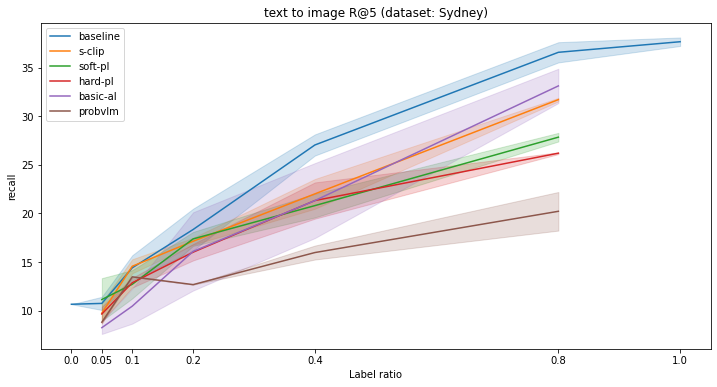

In [20]:
metric = 'text_to_image_R@5'
datasets = ['RSICD', 'UCM', 'Sydney']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)